# Assignment 2

In [1]:
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random
import pandas as pd
import sys
from platform import python_version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split,cross_val_score, KFold, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_recall_fscore_support, make_scorer
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.ensemble import AdaBoostClassifier
# ! pip install xgboost
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.optimizers import Adam, SGD
! pip install "C:\Users\marcu\Desktop\GA Tech\ML\ML-SP24\mlrose"
import mlrose_hiive
from mlrose_hiive.runners import SKMLPRunner
from sklearn.preprocessing import OneHotEncoder


Processing c:\users\marcu\desktop\ga tech\ml\ml-sp24\mlrose
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mlrose-hiive: filename=mlrose_hiive-2.2.4-py3-none-any.whl size=103936 sha256=afdbc6271327c3a580c61a67961a9224fab48356815ee0b48a4334432b9172c8
  Stored in directory: C:\Users\marcu\AppData\Local\Temp\pip-ephem-wheel-cache-fk4_wgc8\wheels\1b\71\20\a26b3f48984937d91461af271cddc3ba8371491b048e63bbfa
Successfully built mlrose-hiive
  Attempting uninstall: mlrose-hiive
    Found existing installation: mlrose-hiive 2.2.4
    Uninstalling mlrose-hiive-2.2.4:
      Successfully uninstalled mlrose-hiive-2.2.4


# Defining functions for Optimization Problem that:
1. Selects the algorithm
2. Varies the model on 3 separate characteristics: fitness/iteration, fitness/problem size, function evaluations

In [3]:
# Define alternative N-Queens fitness function for maximization problem
def queens_max(state):

    # Initialize counter
    fitness_cnt = 0
    
    for i in range(len(state) - 1):
        for j in range(i + 1, len(state)):
            if (state[j] != state[i]) \
                and (state[j] != state[i] + (j - i)) \
                and (state[j] != state[i] - (j - i)):
                
                fitness_cnt+=1
    return fitness_cnt


In [4]:
# Discrete Optimization Problem
def ro(prob = 'nq', algorithm = 'ga', size = 8, 
# Generic Params
                init_state = None, curve = False, random_state = 42, max_attempts = 10, max_iters = 1000,
# RHC params
                 restarts = 0, 
# SA params
                schedule = mlrose_hiive.ExpDecay(), 
# GA params
                pop_size_ga = 200, mutation_prob = 0.1, 
# MIMIC params
                pop_size_mimic = 200, keep_pct = 0.2, fast_mimic = False
#     (problem, max_attempts=10, max_iters=inf, restarts=0, init_state=None, curve=False, random_state=None)
#     (problem, schedule=<mlrose.decay.GeomDecay object>, max_attempts=10, max_iters=inf, init_state=None, curve=False, random_state=None)
#     (problem, pop_size=200, mutation_prob=0.1, max_attempts=10, max_iters=inf, curve=False, random_state=None)
#     (problem, pop_size=200, keep_pct=0.2, max_attempts=10, max_iters=inf, curve=False, random_state=None, fast_mimic=False)
):
        
    # Defining params
#     init_state = params['init_state']
#     curve = params['curve']
#     random_state = params['random_state']
#     max_attempts = params['max_attempts']
#     max_iters = params['max_iters']
#     restarts = params['restarts']
#     schedule = params['schedule']
#     pop_size_ga = params['pop_size_ga']
#     mutation_prob = params['mutation_prob']
#     pop_size_mimic = params['pop_size_mimic']
#     keep_pct = params['keep_pct']
#     fast_mimic = params['fast_mimic']

    best_state_list = []
    best_fitness_list = []
    fitness_curve_list = []
    feval_iteration_list = []
    feval_time_list = []
    df_run_stats_list = [] 
    df_run_curves_list = []
    fc = []


    for x in range(4,-1,-1):
        random.seed(random_state+x)
        np.random.seed(random_state)

        if prob == 'nq':
            fitness = mlrose_hiive.Queens()

            fitness_cust = mlrose_hiive.CustomFitness(queens_max)

            # Define alternative N-Queens fitness function for maximization problem
            problem = mlrose_hiive.DiscreteOpt(length = size, fitness_fn = fitness_cust, maximize = True, max_val = 8)

            # Define decay schedule
        #     schedule = params['schedule']

            # Define initial state
            init_state = np.arange(size)
        elif prob == 'tsp':
            # Initializing coordinates
            list_coord = []
            for i in range(0, size):
                random.seed(42 + i)
                tuple_coord = (random.randint(0, size*5), random.randint(0,size*5))
                list_coord.append(tuple_coord)

            coord_tuple = tuple(list_coord)

            # Initialize fitness function object using coords_list
            fitness_coords = mlrose_hiive.TravellingSales(coords = coord_tuple)

            # Define optimization problem object
            problem = mlrose_hiive.TSPOpt(length = size, coords = coord_tuple, maximize=False)
        elif prob == 'contp':
            fitness = mlrose_hiive.ContinuousPeaks()
            problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True)
            problem.mimic_speed = True


        if algorithm == 'rhc':
            best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                                      max_attempts = max_attempts,
                                                                                      max_iters = max_iters,
                                                                                      restarts = restarts,
                                                                                      init_state = init_state,
                                                                                      curve = curve,
                                                                                      random_state = random_state)
            runner = mlrose_hiive.RHCRunner(problem=problem,
                                            experiment_name=f'{ro}_rhc',
    #                                         output_directory='.',
                                            seed=random_state,
                                            iteration_list=[max_iters],
                                            max_attempts=max_attempts,
                                            restart_list=[restarts]
                                           )   


        elif algorithm == 'sa':
            best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(problem, 
                                                                                       schedule = schedule,
                                                                                       max_attempts = max_attempts, 
                                                                                       max_iters = max_iters,
                                                                                       init_state = init_state, 
                                                                                       curve = curve,
                                                                                       random_state = random_state
                                                                                      )
            runner = mlrose_hiive.SARunner(problem=problem, 
                                           experiment_name=f'{ro}_sa', 
    #                                        output_directory='.', 
                                           seed=random_state,
                                           max_attempts = max_attempts,
                                           iteration_list=[max_iters],
                                           temperature_list=[1])

        elif algorithm == 'ga':
            best_state, best_fitness, fitness_curve = mlrose_hiive.genetic_alg(problem, 
                                                                               pop_size = pop_size_ga,
                                                                               mutation_prob = mutation_prob, 
                                                                               max_attempts = max_attempts,
                                                                               max_iters = max_iters,
                                                                               curve = curve,
                                                                               random_state = random_state)
            runner = mlrose_hiive.GARunner(problem=problem,
                          experiment_name=f'{ro}_ga',
    #                       output_directory='.',
                          seed=random_state,
                          iteration_list=[max_iters],
                          max_attempts=max_attempts,
                          population_sizes=[pop_size_ga],
                          mutation_rates=[mutation_prob])

        elif algorithm == 'mimic':
            best_state, best_fitness, fitness_curve = mlrose_hiive.mimic(problem, 
                                                                       pop_size = pop_size_mimic,
                                                                       keep_pct = keep_pct,
                                                                       max_attempts = max_attempts,
                                                                       max_iters = max_iters,
                                                                       curve = curve,
                                                                       random_state = random_state
                                                                        )
            runner = mlrose_hiive.MIMICRunner(problem=problem,
                                            experiment_name=f'{ro}_mimic',
                                            #                           output_directory='.',
                                            seed=random_state,
                                            iteration_list=[max_iters],
                                            max_attempts=max_attempts,
                                            keep_percent_list=[keep_pct],
                                            population_sizes = [pop_size_mimic])

        else:
            print('none of the above algorithm')

        # Note that best fitness here refers to a minimize function; hence converting to minimize function
        if prob == 'nq':
            best_fitness = best_fitness
        elif prob == 'tsp':
            best_fitness = best_fitness
        elif prob == 'contp':
            best_fitness = best_fitness
        else:
            print('none of the above algo')

        # Running the runner    
        df_run_stats, df_run_curves = runner.run()
        df_run_stats['feval_iteration'] = df_run_stats['FEvals'] / df_run_stats['Iteration']
        df_run_stats['feval_time'] = df_run_stats['FEvals'] / df_run_stats['Time']
        feval_iteration = df_run_stats.dropna()['feval_iteration'].tolist()
        feval_time = df_run_stats.dropna()['feval_time'].tolist()
        
        best_state_list.append(best_state)
        best_fitness_list.append(best_fitness)
        fitness_curve_list.append(fitness_curve)
        size = size
        feval_iteration_list.append(feval_iteration)
        feval_time_list.append(feval_time)
        df_run_stats_list.append(df_run_stats)
        df_run_curves_list.append(df_run_curves)
        
#         print(x)
        if x == 0:
            best_fitness = sum(best_fitness_list) / len(best_fitness_list)

            for y in range(0,len(fitness_curve_list[0])):
                fc_temp = []
                fc_temp.append((fitness_curve_list[0][y][0]+fitness_curve_list[1][y][0]+fitness_curve_list[2][y][0]+fitness_curve_list[3][y][0]+fitness_curve_list[4][y][0])/5)
                fc_temp.append((fitness_curve_list[0][y][1]+fitness_curve_list[1][y][1]+fitness_curve_list[2][y][1]+fitness_curve_list[3][y][1]+fitness_curve_list[4][y][1])/5)
                fc.append(fc_temp)
#             print(fitness_curve_list)
        
    return(best_state, best_fitness, fc, size, feval_iteration, feval_time, df_run_stats, df_run_curves)

                                                               

# 1.0 Optimized Hyperparameters for N Queen

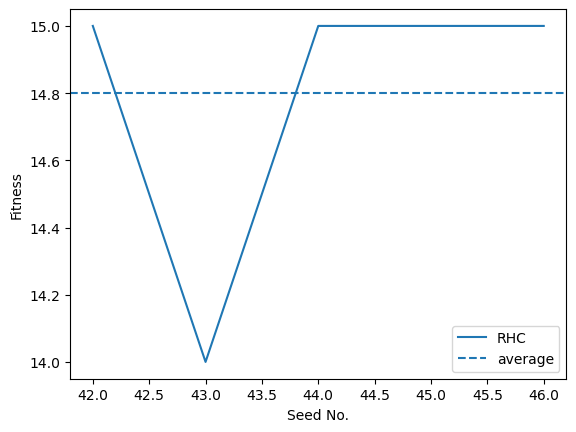

In [8]:
fitness = mlrose_hiive.Queens()

fitness_cust = mlrose_hiive.CustomFitness(queens_max)

# Define alternative N-Queens fitness function for maximization problem
problem = mlrose_hiive.DiscreteOpt(length = 6, fitness_fn = fitness_cust, maximize = True, max_val = 6)

# Define initial state
init_state = np.arange(6)
runner = mlrose_hiive.RHCRunner(problem=problem,
                                        experiment_name=f'{ro}_rhc',
#                                         output_directory='.',
                                        seed=42,
                                        iteration_list=[200, 300, 400, 500, 600],
                                        max_attempts=100,
                                        restart_list=[0,1,2,3,4])   
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('nq_rhc.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                          max_attempts = 100,
                                                                          max_iters = 200,
                                                                          restarts = 4,
                                                                          init_state = None,
                                                                          curve = True,
                                                                          random_state = 42+i)
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='RHC')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')


# max_iter = 200, restart = 4, max_attempts = 100

    
    

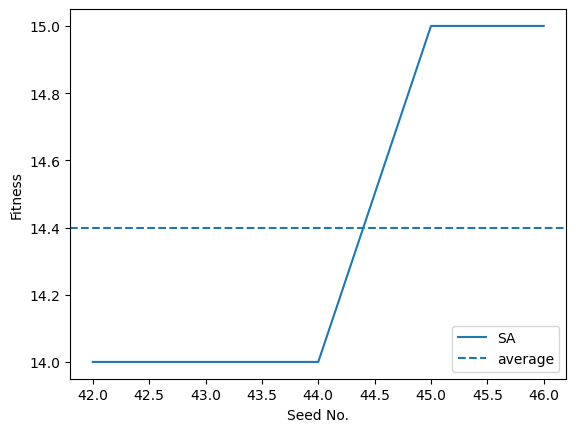

In [10]:
runner = mlrose_hiive.SARunner(problem=problem, 
                               experiment_name=f'{ro}_sa', 
#                                        output_directory='.', 
                               seed=42,
                               max_attempts = 500,
                               iteration_list=[100, 200, 300, 400, 500],
                               temperature_list=[10000,1000000,100000000,10000000000,1000000000000])
#                                ,
#                                decay_list=[mlrose_hiive.ExpDecay(),
#                                            mlrose_hiive.GeomDecay(), 
#                                            mlrose_hiive.ExpDecay()]
                              
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('nq_sa.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(problem, 
                                                                                   schedule = mlrose_hiive.GeomDecay(),
                                                                                   max_attempts = 500, 
                                                                                   max_iters = 500,
                                                                                   init_state = None, 
                                                                                   curve = True,
                                                                                   random_state = 42+i
                                                                                  )
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='SA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# max attempts = 500, schedule: geometric, temperature = 10000, max_iters = 500



ERROR:root:Problem restoring SIGNINT handler


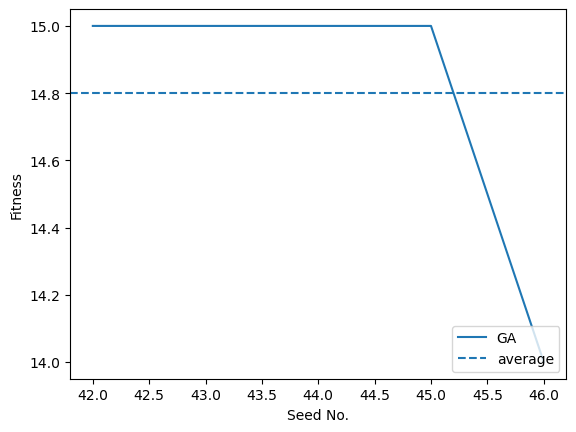

In [122]:
runner = mlrose_hiive.GARunner(problem=problem,
                      experiment_name=f'{ro}_ga',
#                       output_directory='.',
                      seed=42,
                      iteration_list=[100],
                      max_attempts=100,
                      population_sizes=[50, 100, 150, 200, 250, 300, 350, 400],
                      mutation_rates=[0.1, 0.2, 0.3, 0.4, 0.5])
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('nq_ga.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.genetic_alg(problem, 
                                                                           pop_size = 100,
                                                                           mutation_prob = 0.2, 
                                                                           max_attempts = 100,
                                                                           max_iters = 500,
                                                                           curve = True,
                                                                           random_state = 42+i)
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='GA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')


# mutation rate = 0.2, popsize = 100, iter = 500

ERROR:root:Problem restoring SIGNINT handler


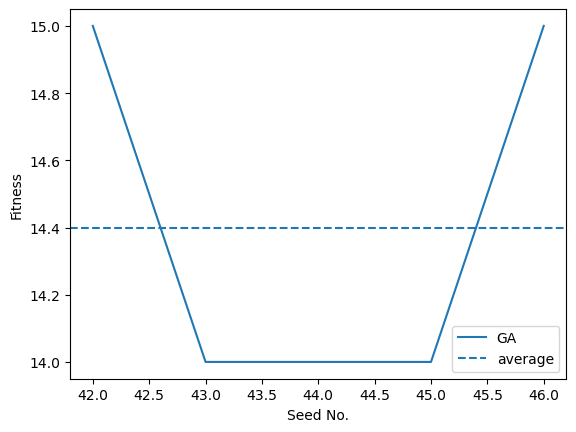

In [123]:
runner = mlrose_hiive.MIMICRunner(problem=problem,
                                experiment_name=f'{ro}_mimic',
                                #                           output_directory='.',
                                seed=42,
                                iteration_list=[500],
                                max_attempts=100,
                                keep_percent_list=[0.1,0.2,0.3,0.4,0.5],
                                population_sizes = [50,100,150,200,250])
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('nq_mimic.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.mimic(problem, 
                                                                   pop_size = 150,
                                                                   keep_pct = 0.4,
                                                                   max_attempts = 100,
                                                                   max_iters = 500,
                                                                   curve = True,
                                                                   random_state = 42+i
#                                                                      ,
#                                                                    fast_mimic = fast_mimic
                                                                    )
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='GA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# population size: 150, Keep pct: 0.4, max_iters: 500, max_attempt = 100

# 1.1 N Queen Optimization Problem - Fitness Per Iteration

In [79]:
# RHC
print('RHC')
start_time = time.time()
rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'nq', 
                algorithm = 'rhc', 
                restarts = 2,
                size = 7,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = 200)
end_time = time.time()
rhc_time = end_time - start_time                                                                                  
print(rhc_time)

RHC
0.331834077835083


In [80]:
# SA
print('SA')
start_time = time.time()
sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'nq', 
                  algorithm = 'sa', 
                  size = 7,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 500, 
                  max_iters = 500,
                  schedule = mlrose_hiive.GeomDecay(init_temp=10000))
end_time = time.time()
sa_time = end_time - start_time
print(sa_time)


SA
0.330394983291626


In [81]:
# mutation rate = 0.2, popsize = 100, iter = 500
# GA
print('GA')
start_time = time.time()
ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'ga', 
                    size = 7,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_ga = 100, 
                    mutation_prob = 0.2)
end_time = time.time()
ga_time = end_time - start_time
print(ga_time)

GA
4.937718152999878


In [82]:
# MIMIC
print('MIMIC')
start_time = time.time()
m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'mimic', 
                    size = 7,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_mimic = 150, 
                    keep_pct = 0.4)
#                     , 
#                     fast_mimic = False
end_time = time.time()
m_time = end_time - start_time      
print(m_time)
# population size: 150, Keep pct: 0.4, max_iters: 500, max_attempt = 100

MIMIC
18.752058029174805


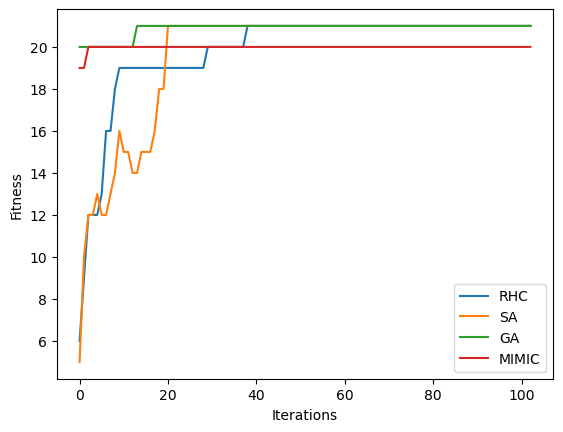

In [46]:
# n Queens - Fitness per iteration!

rhc = []
sa = []
ga = []
mimic = []

for i in range(0,min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve))):    
    rhc.append(rhc_fitness_curve[i][0])
    sa.append(sa_fitness_curve[i][0])
    ga.append(ga_fitness_curve[i][0])
    mimic.append(m_fitness_curve[i][0])

plt.clf()
x = np.arange(min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve)))
plt.plot(x, rhc, label='RHC')
plt.plot(x, sa, label='SA')
plt.plot(x, ga, label='GA')
plt.plot(x, mimic, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# plt.show()
# print(x)

In [785]:
# Takeaway: GA performs best, third best in terms of time; mimic is the slowest
# SA performs terribly, even worse than RHC at some time. But they end up finding global optimum 
# RHC never achieves global optimum, MIMIC will be close to global optimum, but will never reach it as well
print(rhc_fitness_curve[-1])
print(sa_fitness_curve[-1])
print(ga_fitness_curve[-1])
print(m_fitness_curve[-1])

[ 25. 123.]
[ 28. 319.]
[   28. 24725.]
[   27. 20906.]


# 1.2 N Queen Optimization Problem - Fitness per Size

2
0.2177414894104004
0.17301082611083984
2.2355265617370605


1.5241339206695557
['RHC', 'SA', 'GA', 'MIMIC'] [1.0, 1.0, 1.0, 1.0]


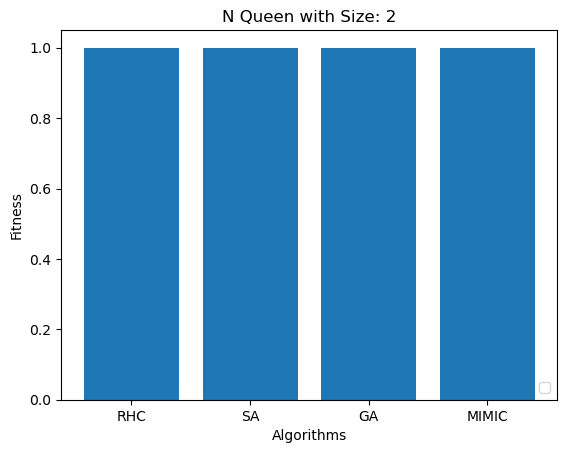

3
0.21696114540100098
0.18630671501159668
2.358999013900757


3.0001065731048584
['RHC', 'SA', 'GA', 'MIMIC'] [3.0, 3.0, 3.0, 3.0]


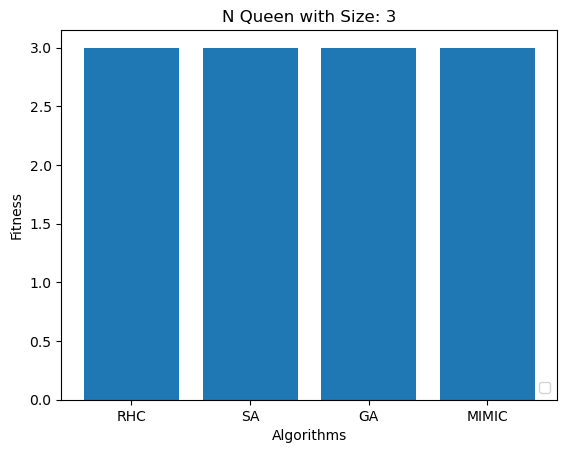

4
0.2485666275024414
0.17883706092834473
2.5492641925811768


4.771398544311523
['RHC', 'SA', 'GA', 'MIMIC'] [6.0, 6.0, 6.0, 6.0]


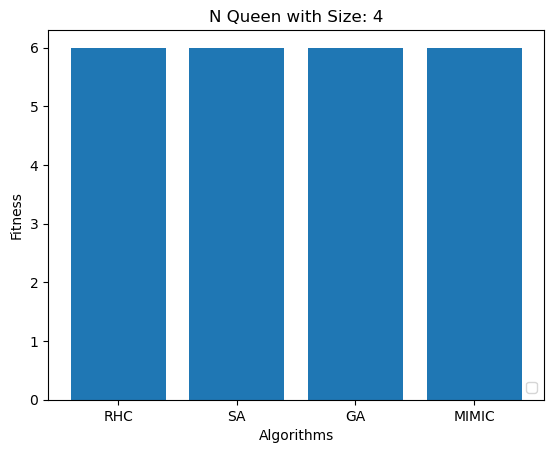

5
0.2547919750213623
0.1943521499633789
2.7698633670806885


7.253493547439575
['RHC', 'SA', 'GA', 'MIMIC'] [10.0, 10.0, 10.0, 10.0]


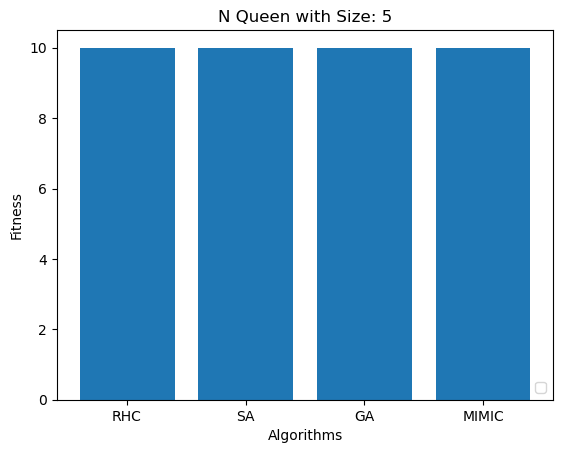

6
0.37603020668029785
0.23643922805786133
3.1807241439819336


9.40198040008545
['RHC', 'SA', 'GA', 'MIMIC'] [15.0, 15.0, 15.0, 15.0]


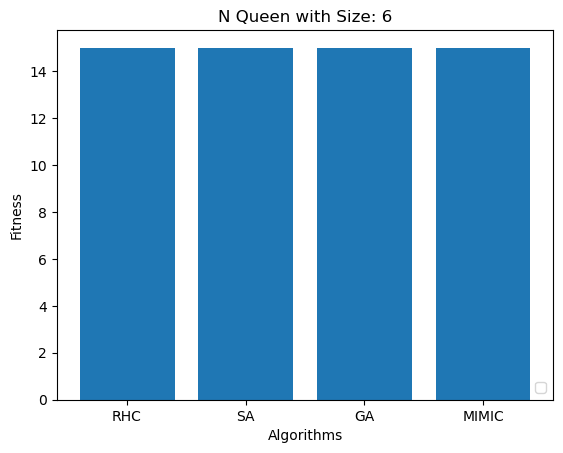

7
0.36609482765197754
0.20678997039794922
3.6375489234924316


13.304190158843994
['RHC', 'SA', 'GA', 'MIMIC'] [21.0, 21.0, 21.0, 20.0]


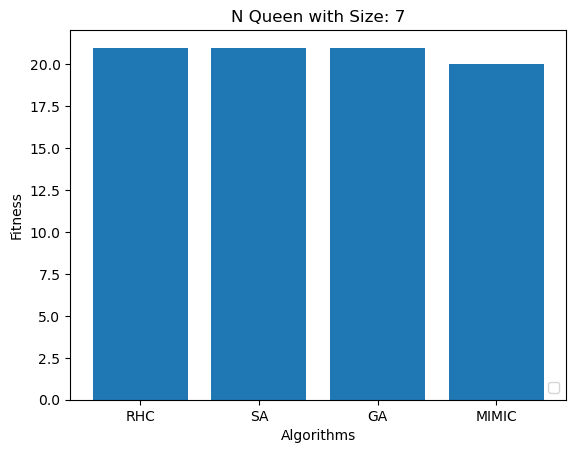

8
0.4143345355987549
0.25530552864074707
4.432283401489258


17.06832790374756
['RHC', 'SA', 'GA', 'MIMIC'] [27.0, 28.0, 28.0, 27.0]


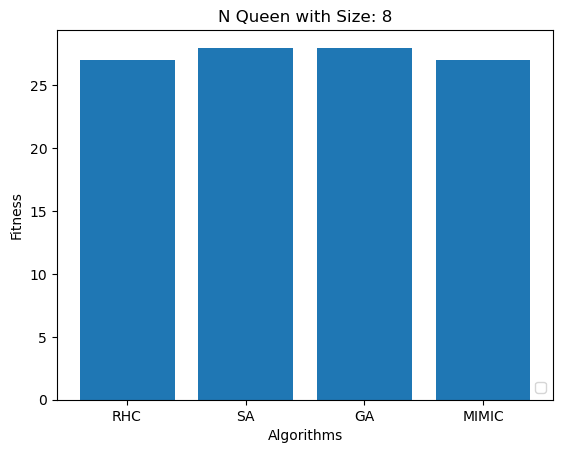

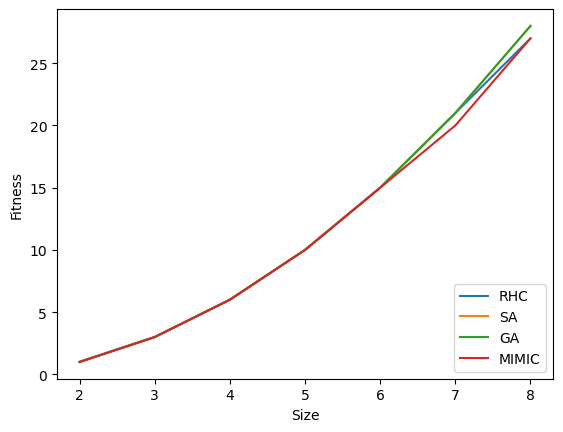

In [78]:
# max_iter = 100, restart = 4, max_attempts = 100
# max attempts = 500, schedule: geometric, temperature = 1, max_iters = 500
# mutation rate = 0.2, popsize = 100, iter = 500
# population size: 150, Keep pct: 0.4, max_iters: 500, max_attempt = 100

rhc_s = []
sa_s = []
ga_s = []
mimic_s = []

for i in range (2, 9):
    print(i)
    start_time = time.time()
    rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'nq', 
                algorithm = 'rhc', 
                restarts = 4,
                size = i,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = 200)
    end_time = time.time()
    rhc_s_time = end_time - start_time  
    print(rhc_s_time)
    
    start_time = time.time()
    sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'nq', 
                  algorithm = 'sa', 
                  size = i,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 500, 
                  max_iters = 500,
                  schedule = mlrose_hiive.GeomDecay())
    end_time = time.time()
    sa_s_time = end_time - start_time 
    print(sa_s_time)
    
    start_time = time.time()
    ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'ga', 
                    size = i,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_ga = 100, 
                    mutation_prob = 0.2)
    end_time = time.time()
    ga_s_time = end_time - start_time 
    print(ga_s_time)
    
    start_time = time.time()
    m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'mimic', 
                    size = i,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_mimic = 150, 
                    keep_pct = 0.4)
    end_time = time.time()
    m_s_time = end_time - start_time 
    print(m_s_time)
        
    rhc_s.append(rhc_best_fitness)
    sa_s.append(sa_best_fitness)
    ga_s.append(ga_best_fitness)
    mimic_s.append(m_best_fitness)

    categories = ['RHC','SA','GA','MIMIC']
    values = [rhc_best_fitness, sa_best_fitness, ga_best_fitness, m_best_fitness]
    
    print(categories,values)
    plt.clf()
    plt.bar(categories, values)

    plt.xlabel('Algorithms')
    plt.ylabel('Fitness')
    plt.title(f'N Queen with Size: {i}')
    plt.legend(loc = 'lower right')    
    plt.show()

# Display the plot
plt.show()
plt.clf()
x = np.arange(2,9)
plt.plot(x, rhc_s, label='RHC')
plt.plot(x, sa_s, label='SA')
plt.plot(x, ga_s, label='GA')
plt.plot(x, mimic_s, label='MIMIC')

# Adding labels and legend
plt.xlabel('Size')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')    


In [731]:
# Takeaway: Expected to have an upward graph since as number of queens increase
# Need to share that SA numbers is actually aligned with GA
# at low iterations, SA sucks, higher iterations, we see major improvement as compared to GA;
# GA is consistently at the best regardless of iteration count
# Slowest is MIMIC - interesting insight, MIMIC tend to perform fast at lower size, but at higher size, it is highly inefficient
# RHC never achieves optimum

[1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0]
[1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0]


In [794]:
print(rhc_s)
print(sa_s)
print(ga_s)
print(mimic_s)

[1.0, 3.0, 6.0, 10.0, 15.0, 19.0, 25.0]
[1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0]
[1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0]
[1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 27.0]


In [720]:
# Sample example of SA performing worse at lower max_iters
# Takeaway at lower max iters - GA = MIMIC fitness

2
0.005042076110839844
0.006780385971069336
0.6879534721374512
0.13496065139770508
3
0.005003452301025391
0.004080533981323242
0.6876809597015381
0.23122072219848633
4
0.008497476577758789
0.007126331329345703
0.8354921340942383
0.375622034072876
5
0.010103940963745117
0.0
0.7543497085571289
0.49582552909851074
6
0.009630441665649414
0.008742094039916992
0.8430612087249756
0.6786110401153564
7
0.009804487228393555
0.005068302154541016
0.8651416301727295
0.9100596904754639
8
0.010213136672973633
0.005553722381591797
0.9556276798248291
1.2238118648529053


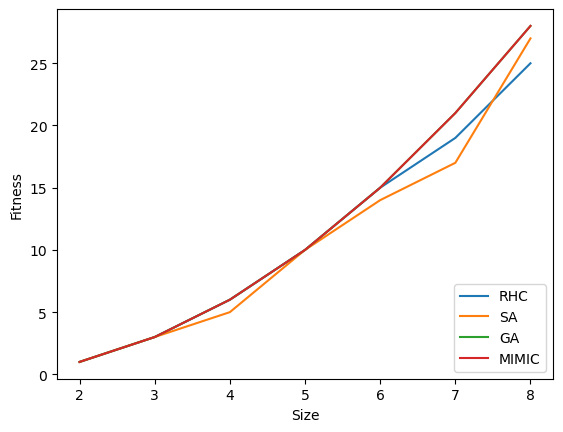

In [760]:
rhc_s = []
sa_s = []
ga_s = []
mimic_s = []

for i in range (2, 9):
    print(i)
    start_time = time.time()
    rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'nq', 
                algorithm = 'rhc', 
                restarts = 0,
                size = i,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 200, 
                max_iters = 100)
    end_time = time.time()
    rhc_s_time = end_time - start_time  
    print(rhc_s_time)
    
    start_time = time.time()
    sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'nq', 
                  algorithm = 'sa', 
                  size = i,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 100, 
                  max_iters = 100,
                  schedule = mlrose_hiive.ExpDecay())
    end_time = time.time()
    sa_s_time = end_time - start_time 
    print(sa_s_time)
    
    start_time = time.time()
    ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'ga', 
                    size = i,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 100,
                    pop_size_ga = 200, 
                    mutation_prob = 0.01)
    end_time = time.time()
    ga_s_time = end_time - start_time 
    print(ga_s_time)
    
    start_time = time.time()
    m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'mimic', 
                    size = i,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 50, 
                    max_iters = 100,
                    pop_size_mimic = 100, 
                    keep_pct = 0.2)
    end_time = time.time()
    m_s_time = end_time - start_time 
    print(m_s_time)
        
    rhc_s.append(rhc_best_fitness)
    sa_s.append(sa_best_fitness)
    ga_s.append(ga_best_fitness)
    mimic_s.append(m_best_fitness)


plt.clf()
x = np.arange(2,9)
plt.plot(x, rhc_s, label='RHC')
plt.plot(x, sa_s, label='SA')
plt.plot(x, ga_s, label='GA')
plt.plot(x, mimic_s, label='MIMIC')

# Adding labels and legend
plt.xlabel('Size')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')   

# 1.3 N Queen Optimization Problem - FEval per iteration

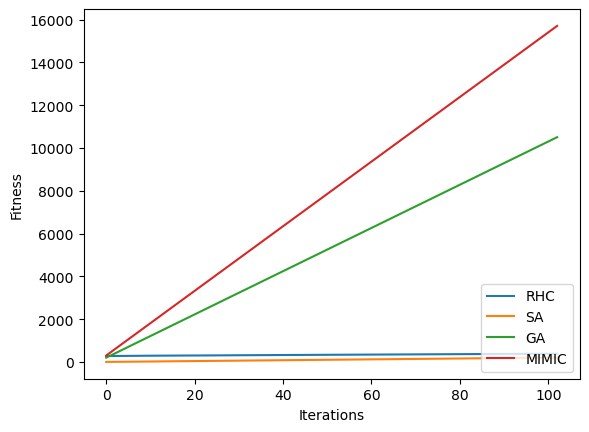

In [84]:
# n Queens - Fitness per iteration!

rhc = []
sa = []
ga = []
mimic = []

for i in range(0,min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve))):    
    rhc.append(rhc_fitness_curve[i][1])
    sa.append(sa_fitness_curve[i][1])
    ga.append(ga_fitness_curve[i][1])
    mimic.append(m_fitness_curve[i][1])

plt.clf()
x = np.arange(min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve)))
plt.plot(x, rhc, label='RHC')
plt.plot(x, sa, label='SA')
plt.plot(x, ga, label='GA')
plt.plot(x, mimic, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# plt.show()
# print(x)

ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


5
0.014369726181030273
0.0070037841796875
0.054045677185058594


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.15950822830200195
10
0.0200045108795166
0.006994724273681641
0.10341215133666992


ERROR:root:Problem restoring SIGNINT handler


0.3096439838409424


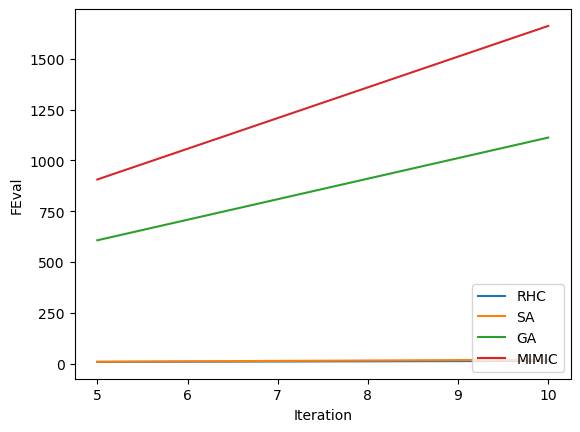

In [59]:
# Using run_stats to get fevals for smaller iterations

# max_iter = 100, restart = 4, max_attempts = 100
# max attempts = 500, schedule: geometric, temperature = 1, max_iters = 500
# mutation rate = 0.2, popsize = 100, iter = 500
# population size: 150, Keep pct: 0.4, max_iters: 500, max_attempt = 100

rhc_fe = []
sa_fe = []
ga_fe = []
m_fe = []
x = []

for i in range(5,15,5):
    print(i)
    start_time = time.time()
    rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'nq', 
                algorithm = 'rhc', 
                restarts = 4,
                size = 6,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = i)
    end_time = time.time()
    rhc_fe_time = end_time - start_time  
    print(rhc_fe_time)
    
    start_time = time.time()
    sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'nq', 
                  algorithm = 'sa', 
                  size = 6,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 500, 
                  max_iters = i,
                  schedule = mlrose_hiive.GeomDecay())
    end_time = time.time()
    sa_fe_time = end_time - start_time 
    print(sa_fe_time)
    
    start_time = time.time()
    ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'ga', 
                    size = 6,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = i,
                    pop_size_ga = 100, 
                    mutation_prob = 0.2)
    end_time = time.time()
    ga_fe_time = end_time - start_time 
    print(ga_fe_time)
    
    start_time = time.time()
    m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'nq', 
                    algorithm = 'mimic', 
                    size = 6,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = i,
                    pop_size_mimic = 150, 
                    keep_pct = 0.4)
    end_time = time.time()
    m_fe_time = end_time - start_time 
    print(m_fe_time)
    
    x.append(i)

    specific_rows = rhc_df_run_stats[rhc_df_run_stats['Iteration'] == i].reset_index()
    rhc_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = sa_df_run_stats[sa_df_run_stats['Iteration'] == i].reset_index()
    sa_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = ga_df_run_stats[ga_df_run_stats['Iteration'] == i].reset_index()
    ga_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = m_df_run_stats[m_df_run_stats['Iteration'] == i].reset_index()
    m_fe.append(specific_rows.loc[0, 'FEvals'])
        

plt.clf()
plt.plot(x, rhc_fe, label='RHC')
plt.plot(x, sa_fe, label='SA')
plt.plot(x, ga_fe, label='GA')
plt.plot(x, m_fe, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('FEval')
plt.legend(loc = 'lower right')

In [ ]:
# Takeaway: at lower values of iteration, we can see the distinct lines between the 4 lines.
# At higher values of iterations, GA will have more FEval than MIMIC considering the same population size.
# RHC has the lowest FEval per iteration.

# 2.0 TSP Optimized Hyperparameters 

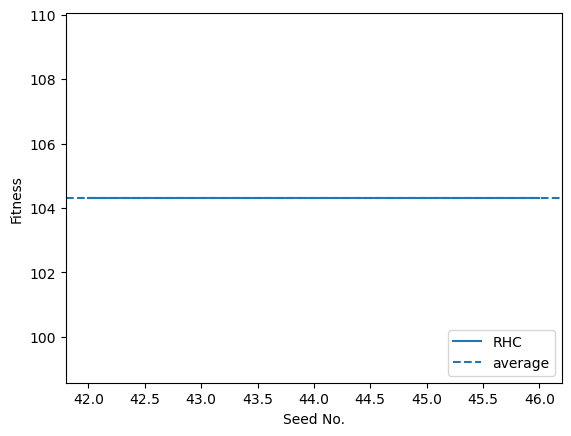

In [6]:
size = 8

list_coord = []
for i in range(0, size):
    random.seed(42 + i)
    tuple_coord = (random.randint(0, size*5), random.randint(0,size*5))
    list_coord.append(tuple_coord)

coord_tuple = tuple(list_coord)

# Initialize fitness function object using coords_list
fitness_coords = mlrose_hiive.TravellingSales(coords = coord_tuple)

# Define optimization problem object
problem = mlrose_hiive.TSPOpt(length = size, coords = coord_tuple, maximize=False)

runner = mlrose_hiive.RHCRunner(problem=problem,
                                        experiment_name=f'{ro}_rhc',
#                                         output_directory='.',
                                        seed=42,
                                        iteration_list=[100, 200, 300, 400, 500],
                                        max_attempts=100,
                                        restart_list=[1,2,3,4,5])   
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('tsp_rhc.csv')

# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                          max_attempts = 100,
                                                                          max_iters = 500,
                                                                          restarts = 1,
                                                                          init_state = None,
                                                                          curve = True,
                                                                          random_state = 42+i)
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='RHC')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')
# max_iters = 500, max_attempts = 100, restart = 1



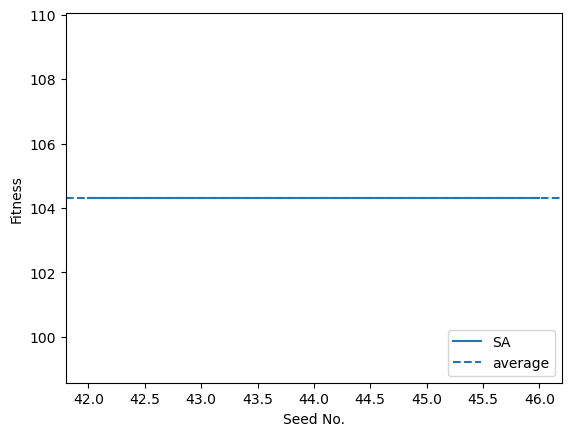

In [15]:
runner = mlrose_hiive.SARunner(problem=problem, 
                               experiment_name=f'{ro}_sa', 
#                                        output_directory='.', 
                               seed=42,
                               max_attempts = 500,
                               iteration_list=[100, 200, 300, 400, 500],
                               temperature_list=[1,10000,1000000,100000000,10000000000,1000000000000]
#                                ,
#                                decay_list=[mlrose_hiive.ExpDecay(),
#                                            mlrose_hiive.GeomDecay(), 
#                                            mlrose_hiive.ExpDecay()]
                              )
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('tsp_sa.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(problem, 
                                                                                   schedule = mlrose_hiive.GeomDecay(),
                                                                                   max_attempts = 500, 
                                                                                   max_iters = 500,
                                                                                   init_state = None, 
                                                                                   curve = True,
                                                                                   random_state = 42+i
                                                                                  )
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='SA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')


# max attempts = 500, schedule: geometric, temperature = 1, max_iters = 500




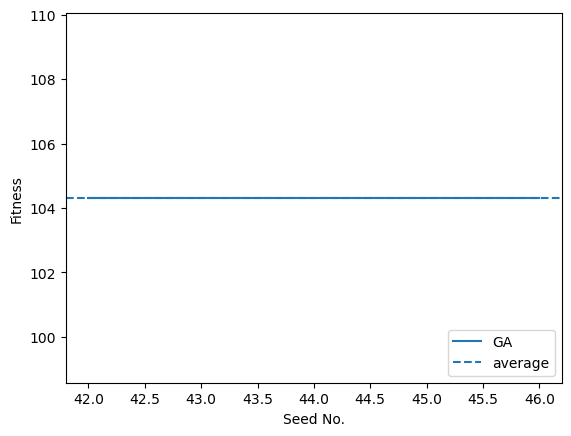

In [10]:
size = 8

runner = mlrose_hiive.GARunner(problem=problem,
                      experiment_name=f'{ro}_ga',
#                       output_directory='.',
                      seed=42,
                      iteration_list=[100, 200, 300, 400, 500],
                      max_attempts=100,
                      population_sizes=[2, 100, 200, 300],
                      mutation_rates=[0.2, 0.3, 0.4, 0.5])
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('tsp_ga.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.genetic_alg(problem, 
                                                                           pop_size = 100,
                                                                           mutation_prob = 0.2, 
                                                                           max_attempts = 100,
                                                                           max_iters = 500,
                                                                           curve = True,
                                                                           random_state = 42+i)
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='GA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')


# mutation rate = 0.2, popsize = 100, iter = 500, max attempt: 100



ERROR:root:Problem restoring SIGNINT handler


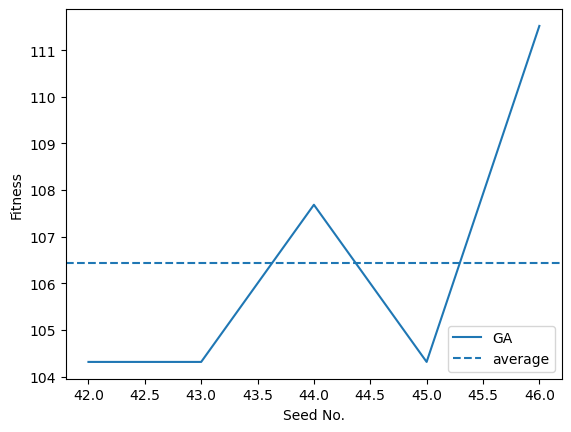

In [127]:
runner = mlrose_hiive.MIMICRunner(problem=problem,
                                experiment_name=f'{ro}_mimic',
                                #                           output_directory='.',
                                seed=42,
                                iteration_list=[100,200,300,400,500],
                                max_attempts=100,
                                keep_percent_list=[0.1,0.2,0.3,0.4,0.5],
                                population_sizes = [50,100,150,200,250])
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('tsp_mimic.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.mimic(problem, 
                                                                   pop_size = 150,
                                                                   keep_pct = 0.2,
                                                                   max_attempts = 100,
                                                                   max_iters = 500,
                                                                   curve = True,
                                                                   random_state = 42+i
#                                                                      ,
#                                                                    fast_mimic = fast_mimic
                                                                    )
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='GA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# population size: 150, Keep pct: 0.2, max_iters: 500, max_attempt = 100

# 2.1 TSP Optimization Problem - Fitness Per Iteration

In [85]:
# RHC
print('RHC')
start_time = time.time()
rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'tsp', 
                algorithm = 'rhc', 
                restarts = 1,
                size = 7,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = 500)
end_time = time.time()
rhc_time = end_time - start_time                                                                                  
print(rhc_time)


# SA
print('SA')
start_time = time.time()
sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'tsp', 
                  algorithm = 'sa', 
                  size = 7,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 500, 
                  max_iters = 500,
                  schedule = mlrose_hiive.GeomDecay()
#     ExpDecay(init_temp=0.9, exp_const=0.01)
)
end_time = time.time()
sa_time = end_time - start_time
print(sa_time)


# GA
print('GA')
start_time = time.time()
ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'tsp', 
                    algorithm = 'ga', 
                    size = 7,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_ga = 100, 
                    mutation_prob = 0.2)
end_time = time.time()
ga_time = end_time - start_time
print(ga_time)

# MIMIC
print('MIMIC')
start_time = time.time()
m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'tsp', 
                    algorithm = 'mimic', 
                    size = 7,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_mimic = 150, 
                    keep_pct = 0.2)
#                     , 
#                     fast_mimic = False
end_time = time.time()
m_time = end_time - start_time      
print(m_time)

RHC
0.1761786937713623
SA
0.35698556900024414
GA
5.659940719604492
MIMIC
42.73110222816467


In [82]:
# m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
#                     prob = 'tsp', 
#                     algorithm = 'mimic', 
#                     size = 8,
#                     init_state = None, 
#                     curve = True, 
#                     random_state = 42, 
#                     max_attempts = 100, 
#                     max_iters = 600,
#                     pop_size_mimic = 200, 
#                     keep_pct = 0.4)
print(m_best_fitness)

104.31347041678433


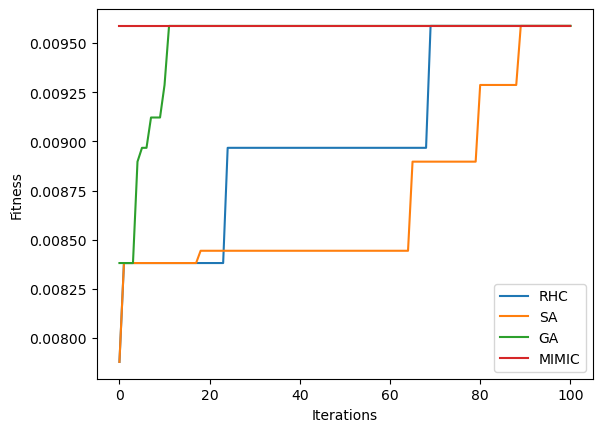

In [204]:
# Fitness per iteration!

rhc = []
sa = []
ga = []
mimic = []

for i in range(0,min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve))):    
    rhc.append(1/rhc_fitness_curve[i][0])
    sa.append(1/sa_fitness_curve[i][0])
    ga.append(1/ga_fitness_curve[i][0])
    mimic.append(1/m_fitness_curve[i][0])

plt.clf()
x = np.arange(min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve)))
plt.plot(x, rhc, label='RHC')
plt.plot(x, sa, label='SA')
plt.plot(x, ga, label='GA')
plt.plot(x, mimic, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# plt.show()
# print(x)

In [860]:
# print(m_fitness_curve)
# Takeaway: Mimic is good for smaller number of nodes. Genetic and MIMIC are around the same when size is below 7.
# Long time to convergence (almost 6 times longer than the previous slowest runtime) but get to convergence almost immediately
# Will not get to convergence for RHC and SA if max_iter is below 100!

# 2.2 TSP Optimization Problem - Fitness Per Size

ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


4
0.046074867248535156
0.11843442916870117


ERROR:root:Problem restoring SIGNINT handler


0.9311845302581787


ERROR:root:Problem restoring SIGNINT handler


13.464401245117188


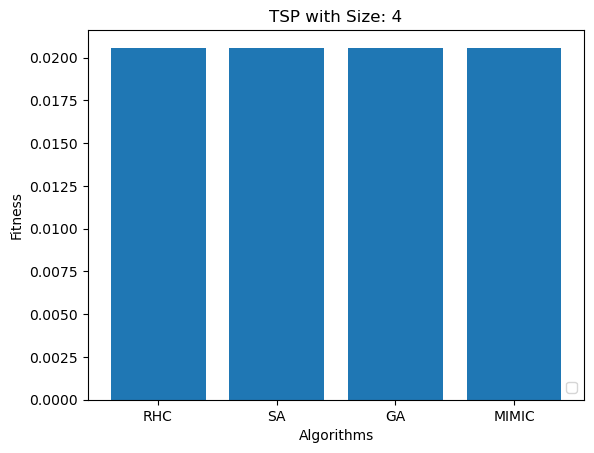

ERROR:root:Problem restoring SIGNINT handler


5
0.029077529907226562


ERROR:root:Problem restoring SIGNINT handler


0.10026288032531738


ERROR:root:Problem restoring SIGNINT handler


0.9698488712310791


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


16.650203227996826
6
0.03567361831665039
0.09423494338989258


ERROR:root:Problem restoring SIGNINT handler


1.0518581867218018


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


20.10625958442688
7
0.03904008865356445
0.11614871025085449


ERROR:root:Problem restoring SIGNINT handler


1.1151134967803955


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


23.13039803504944
8
0.041582584381103516
0.10856509208679199


ERROR:root:Problem restoring SIGNINT handler


1.269160509109497


ERROR:root:Problem restoring SIGNINT handler


26.912774324417114


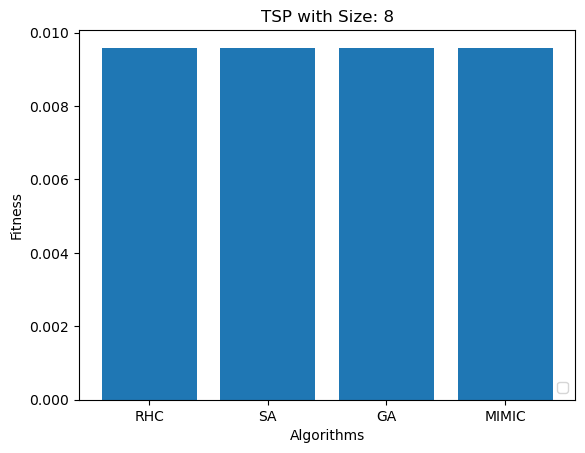

ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


9
0.06470394134521484
0.11521005630493164


ERROR:root:Problem restoring SIGNINT handler


1.3479201793670654


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


30.55071759223938
10
0.11442780494689941
0.11859989166259766


ERROR:root:Problem restoring SIGNINT handler


1.6137964725494385


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


37.90476870536804
11
0.048026323318481445
0.10953664779663086


ERROR:root:Problem restoring SIGNINT handler


1.4341351985931396


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


40.67575764656067
12
0.0845189094543457
0.11647987365722656


ERROR:root:Problem restoring SIGNINT handler


2.4673140048980713


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


46.615326166152954
13
0.06741523742675781
0.07884550094604492


ERROR:root:Problem restoring SIGNINT handler


2.2927277088165283


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


54.44850277900696
14
0.16922807693481445
0.11016726493835449


ERROR:root:Problem restoring SIGNINT handler


2.3464772701263428


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


57.65855312347412
15
0.10973906517028809
0.10018014907836914


ERROR:root:Problem restoring SIGNINT handler


2.162599802017212


ERROR:root:Problem restoring SIGNINT handler


63.93089699745178


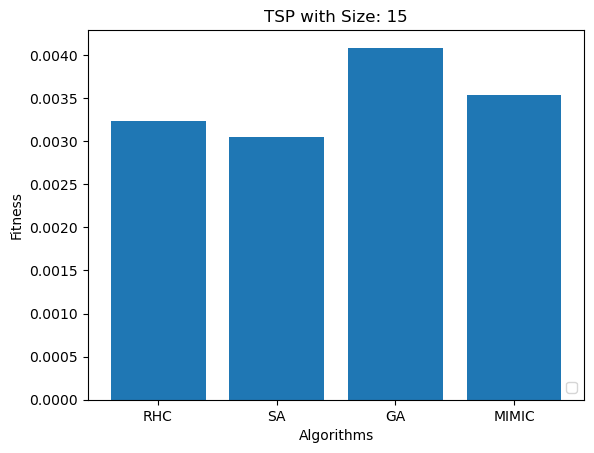

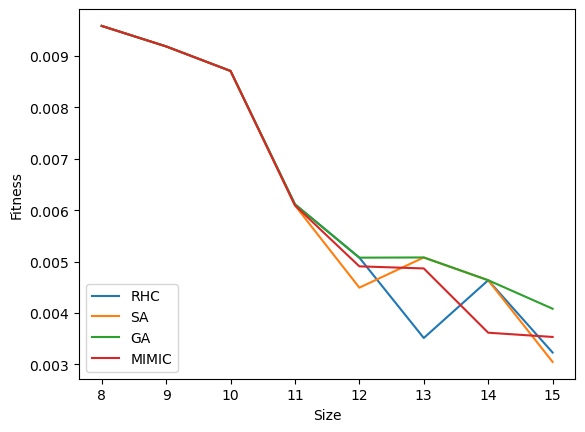

In [71]:
rhc_s = []
sa_s = []
ga_s = []
mimic_s = []

for i in range (4, 16):
    print(i)
    start_time = time.time()
    rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'tsp', 
                algorithm = 'rhc', 
                restarts = 1,
                size = i,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = 500)
    end_time = time.time()
    rhc_s_time = end_time - start_time  
    print(rhc_s_time)
    
    start_time = time.time()
    sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'tsp', 
                  algorithm = 'sa', 
                  size = i,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 500, 
                  max_iters = 500,
                  schedule = mlrose_hiive.GeomDecay())
    end_time = time.time()
    sa_s_time = end_time - start_time 
    print(sa_s_time)
    
    start_time = time.time()
    ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'tsp', 
                    algorithm = 'ga', 
                    size = i,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_ga = 100, 
                    mutation_prob = 0.2)
    end_time = time.time()
    ga_s_time = end_time - start_time 
    print(ga_s_time)
    
    start_time = time.time()
    m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'tsp', 
                    algorithm = 'mimic', 
                    size = i,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500,
                    pop_size_mimic = 500, 
                    keep_pct = 0.2)
    end_time = time.time()
    m_s_time = end_time - start_time 
    print(m_s_time)
        

    
    if i == 4:
        categories = ['RHC','SA','GA','MIMIC']
        values = [1/rhc_best_fitness, 1/sa_best_fitness, 1/ga_best_fitness, 1/m_best_fitness]
        plt.clf()
        plt.bar(categories, values)

        plt.xlabel('Algorithms')
        plt.ylabel('Fitness')
        plt.title(f'TSP with Size: {i}')
        plt.legend(loc = 'lower right')    
        plt.show()

    elif i == 8:
        
        categories = ['RHC','SA','GA','MIMIC']
        values = [1/rhc_best_fitness, 1/sa_best_fitness, 1/ga_best_fitness, 1/m_best_fitness]
        plt.clf()
        plt.bar(categories, values)

        plt.xlabel('Algorithms')
        plt.ylabel('Fitness')
        plt.title(f'TSP with Size: {i}')
        plt.legend(loc = 'lower right')    
        plt.show()
        
    elif i == 15:
        
        categories = ['RHC','SA','GA','MIMIC']
        values = [1/rhc_best_fitness, 1/sa_best_fitness, 1/ga_best_fitness, 1/m_best_fitness]
        plt.clf()
        plt.bar(categories, values)

        plt.xlabel('Algorithms')
        plt.ylabel('Fitness')
        plt.title(f'TSP with Size: {i}')
        plt.legend(loc = 'lower right')    
        plt.show()
        
    if i >= 8:
        rhc_s.append(1/rhc_best_fitness)
        sa_s.append(1/sa_best_fitness)
        ga_s.append(1/ga_best_fitness)
        mimic_s.append(1/m_best_fitness)
        


plt.clf()
x = np.arange(8,16)
plt.plot(x, rhc_s, label='RHC')
plt.plot(x, sa_s, label='SA')
plt.plot(x, ga_s, label='GA')
plt.plot(x, mimic_s, label='MIMIC')

# Adding labels and legend
plt.xlabel('Size')
plt.ylabel('Fitness')
plt.legend(loc = 'lower left')    


In [60]:
# Takeaway: MIMIC performs well with smaller sizes
for i in range (0,len(rhc_s)):
    
    print('printing', i)
    print(rhc_s[i])
    print(sa_s[i])
    print(ga_s[i])
    print(mimic_s[i])
    print()

printing 0
196.92845381934876
222.50889425277887
196.92845381934876
216.77052743863266

printing 1
284.4898388364429
196.77656984510236
196.7765698451024
279.250455136713

printing 2
215.57501408009662
215.57501408009662
215.57501408009662
297.95478062496375

printing 3
309.4006790040304
327.92029181591926
244.8339152067846
360.12432551883774

printing 4
292.1446394608183
255.9006319502344
255.9006319502344
392.33645910827784

printing 5
266.84584170653125
248.25506849987102
248.25506849987102
369.0421210195132

printing 6
248.30487136795568
359.2085125310813
248.30487136795566
365.5246098171669

printing 7
322.2483769680452
333.5095956422783
268.9270057944642
423.19262712058793

printing 8
390.60981623875807
380.4147653160996
299.7723644344446
428.3331720140907

printing 9
366.1210400479579
384.2477071323086
307.8955059804461
511.1344950338152



# 2.3 TSP Optimization Problem - FEval per Iteration

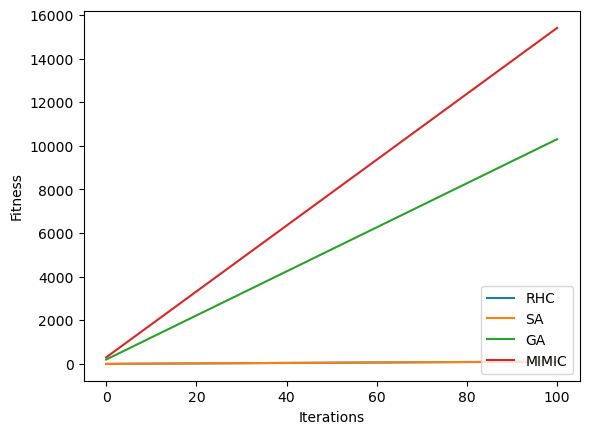

In [87]:
# Fitness per iteration!

rhc = []
sa = []
ga = []
mimic = []

for i in range(0,min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve))):    
    rhc.append(rhc_fitness_curve[i][1])
    sa.append(sa_fitness_curve[i][1])
    ga.append(ga_fitness_curve[i][1])
    mimic.append(m_fitness_curve[i][1])

plt.clf()
x = np.arange(min(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve)))
plt.plot(x, rhc, label='RHC')
plt.plot(x, sa, label='SA')
plt.plot(x, ga, label='GA')
plt.plot(x, mimic, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# plt.show()
# print(x)

ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


5
0.014087677001953125
0.008743524551391602
0.09586405754089355


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


2.1242830753326416
6
0.011107921600341797
0.007004976272583008
0.10176563262939453


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


2.6544857025146484
7
0.012998580932617188
0.007222414016723633
0.11860036849975586


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


3.0665297508239746
8
0.00813150405883789
0.007871150970458984
0.13605642318725586


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


3.418168067932129
9
0.011396408081054688
0.009000301361083984
0.18004441261291504


ERROR:root:Problem restoring SIGNINT handler


3.78550386428833


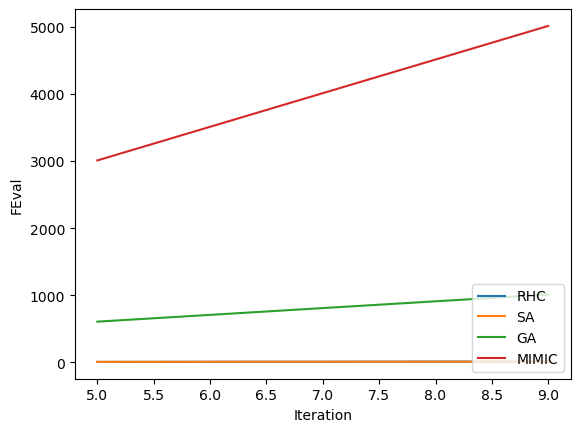

In [72]:
# Using run_stats to get fevals for smaller iterations

rhc_fe = []
sa_fe = []
ga_fe = []
m_fe = []
x = []

for i in range(5,10):
    print(i)
    start_time = time.time()
    rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'tsp', 
                algorithm = 'rhc', 
                restarts = 1,
                size = 12,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = i)
    end_time = time.time()
    rhc_fe_time = end_time - start_time  
    print(rhc_fe_time)
    
    start_time = time.time()
    sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'tsp', 
                  algorithm = 'sa', 
                  size = 12,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 500, 
                  max_iters = i,
                  schedule = mlrose_hiive.GeomDecay())
    end_time = time.time()
    sa_fe_time = end_time - start_time 
    print(sa_fe_time)
    
    start_time = time.time()
    ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'tsp', 
                    algorithm = 'ga', 
                    size = 12,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = i,
                    pop_size_ga = 100, 
                    mutation_prob = 0.2)
    end_time = time.time()
    ga_fe_time = end_time - start_time 
    print(ga_fe_time)
    
    start_time = time.time()
    m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'tsp', 
                    algorithm = 'mimic', 
                    size = 12,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = i,
                    pop_size_mimic = 500, 
                    keep_pct = 0.2)
    end_time = time.time()
    m_fe_time = end_time - start_time 
    print(m_fe_time)
    
    x.append(i)
    
    specific_rows = rhc_df_run_stats[rhc_df_run_stats['Iteration'] == i].reset_index()
    rhc_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = sa_df_run_stats[sa_df_run_stats['Iteration'] == i].reset_index()
    sa_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = ga_df_run_stats[ga_df_run_stats['Iteration'] == i].reset_index()
    ga_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = m_df_run_stats[m_df_run_stats['Iteration'] == i].reset_index()
    m_fe.append(specific_rows.loc[0, 'FEvals'])
        

plt.clf()
plt.plot(x, rhc_fe, label='RHC')
plt.plot(x, sa_fe, label='SA')
plt.plot(x, ga_fe, label='GA')
plt.plot(x, m_fe, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('FEval')
plt.legend(loc = 'lower right')

# 3.0 Continuous Peak Optimized Hyperparameters

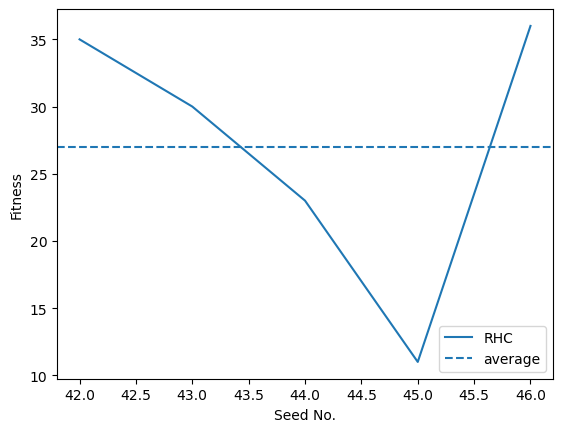

In [10]:
size = 100

fitness = mlrose_hiive.ContinuousPeaks()
problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True)


runner = mlrose_hiive.RHCRunner(problem=problem,
                                        experiment_name=f'{ro}_rhc',
#                                         output_directory='.',
                                        seed=42,
                                        iteration_list=[100,200,300,400,500],
                                        max_attempts=100,
                                        restart_list=[1,2,3,4,5,6,7,8,9,10])   
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('contp_rhc.csv')

# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                          max_attempts = 100,
                                                                          max_iters = 500,
                                                                          restarts = 2,
                                                                          init_state = None,
                                                                          curve = True,
                                                                          random_state = 42+i)
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='RHC')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# max_iters = 500, max_attempts = 100, restart = 2



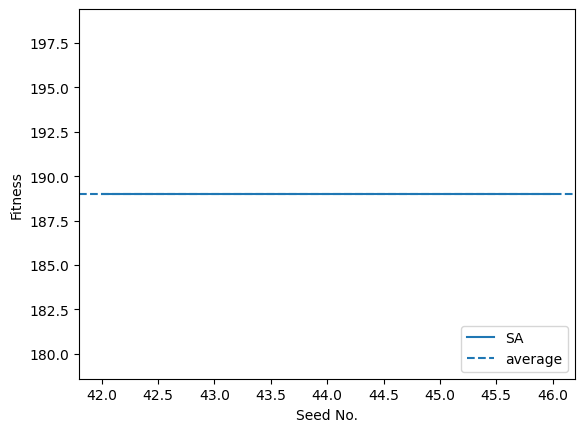

In [8]:
size = 100

fitness = mlrose_hiive.ContinuousPeaks()
problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True)

runner = mlrose_hiive.SARunner(problem=problem, 
                               experiment_name=f'{ro}_sa', 
#                                        output_directory='.', 
                               seed=42,
                               max_attempts = 5000,
                               iteration_list=[1000,2000,3000,4000,5000],
                               temperature_list = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10],
                               decay_list=[mlrose_hiive.GeomDecay, mlrose_hiive.ArithDecay]
                               
#                                decay_list=[
                                   
#                                    mlrose_hiive.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.0001)
#                                    ,
#                                            mlrose_hiive.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001), 
#                                            mlrose_hiive.ArithDecay(init_temp=1.0, decay=0.0001, min_temp=0.001)
#                                ]
                              )

            
            
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('contp_sa.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(
                                                    problem, 
                                                    max_attempts=5000, 
                                                    max_iters=5000, 
                                                    curve=True, 
                                                    random_state=42,
                                                    schedule=mlrose_hiive.GeomDecay(init_temp = 10000, decay=0.99, min_temp=0.1))
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='SA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')


# max attempts = 5000, schedule: geometric, init_temp = 10000, max_iters = 5000




ERROR:root:Problem restoring SIGNINT handler


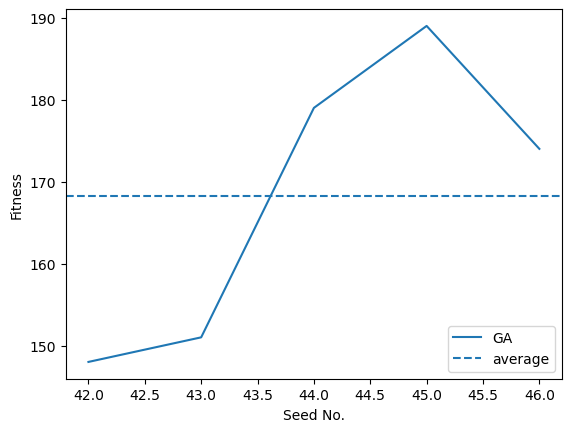

In [69]:
size = 100

fitness = mlrose_hiive.ContinuousPeaks()
problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True)

runner = mlrose_hiive.GARunner(problem=problem,
                      experiment_name=f'{ro}_ga',
#                       output_directory='.',
                      seed=42,
                      iteration_list=[300, 400, 500, 600, 700],
                      max_attempts=100,
                      population_sizes=[50, 100, 150, 200, 250],
                      mutation_rates=[0.1, 0.2, 0.3])
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('contp_ga.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.genetic_alg(problem, 
                                                                           pop_size = 200,
                                                                           mutation_prob = 0.3, 
                                                                           max_attempts = 100,
                                                                           max_iters = 700,
                                                                           curve = True,
                                                                           random_state = 42+i)
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='GA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# mutation rate = 0.4, popsize = 200, iter = 5000, max attempt: 100



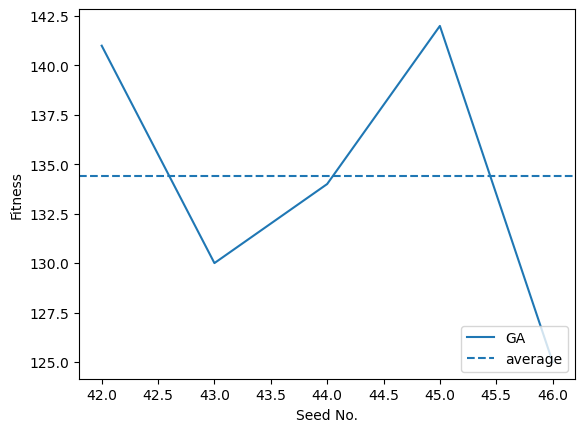

In [19]:
size = 100

fitness = mlrose_hiive.ContinuousPeaks()
problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True)

runner = mlrose_hiive.MIMICRunner(problem=problem,
                                experiment_name=f'{ro}_mimic',
                                #                           output_directory='.',
                                seed=42,
                                iteration_list=[1000,2000,3000,4000,5000],
                                max_attempts=100,
                                keep_percent_list=[0.1,0.2,0.3,0.4,0.5],
                                population_sizes = [50,100,150,200,250])
df_run_stats, df_run_curves = runner.run()
df_run_stats.to_csv('contp_mimic.csv')


# Averaged best fitness
bf = []
x=[]
for i in range(0,5):
    best_state, best_fitness, fitness_curve = mlrose_hiive.mimic(problem, 
                                                                   pop_size = 250,
                                                                   keep_pct = 0.5,
                                                                   max_attempts = 100,
                                                                   max_iters = 5000,
                                                                   curve = True,
                                                                   random_state = 42+i)
    bf.append(best_fitness)
    x.append(42+i)
    
    

plt.clf()
plt.plot(x, bf, label='GA')

# Calculate the average
average_value = np.mean(bf)

# Plotting the data
plt.axhline(average_value,linestyle='--',label = 'average')

# Adding labels and legend
plt.xlabel('Seed No.')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# population size: 250, Keep pct: 0.5, max_iters: 5000, max_attempt = 100

# 3.1  Optimization Problem - Fitness Per Iteration

In [88]:
size = 100

# RHC
print('RHC')
start_time = time.time()
rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'contp', 
                algorithm = 'rhc', 
                restarts = 2,
                size = size,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = 500)
end_time = time.time()
rhc_time = end_time - start_time                                                                                  
print(rhc_time)

# max_iters = 500, max_attempts = 100, restart = 2

# SA
print('SA')
start_time = time.time()
sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'contp', 
                  algorithm = 'sa', 
                  size = size,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 5000, 
                  max_iters = 5000,
                  schedule = mlrose_hiive.GeomDecay(init_temp=10000, decay=0.99, min_temp = 1))
end_time = time.time()
sa_time = end_time - start_time
print(sa_time)

# max attempts = 5000, schedule: geometric, init_temp = 10000, max_iters = 5000, decay=0.99, min_temp=0.1

# GA
print('GA')
start_time = time.time()
ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'contp', 
                    algorithm = 'ga', 
                    size = size,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 700,
                    pop_size_ga = 200, 
                    mutation_prob = 0.3)
end_time = time.time()
ga_time = end_time - start_time
print(ga_time)

# mutation rate = 0.3, popsize = 200, iter = 700, max attempt: 100

# MIMIC
print('MIMIC')
start_time = time.time()
m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'contp', 
                    algorithm = 'mimic', 
                    size = size,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 5000,
                    pop_size_mimic = 250, 
                    keep_pct = 0.5)
#                     , 
#                     fast_mimic = False
end_time = time.time()
m_time = end_time - start_time      
print(m_time)

# population size: 250, Keep pct: 0.5, max_iters: 5000, max_attempt = 100

RHC
0.664402961730957
SA
15.386416673660278
GA
27.605353593826294
MIMIC
3646.0715231895447


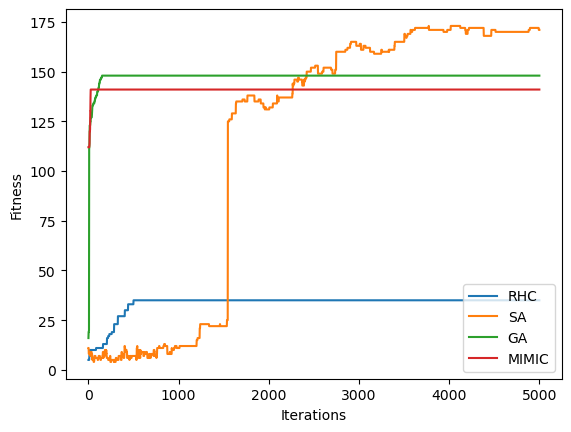

In [68]:
# Fitness per iteration!

rhc = []
sa = []
ga = []
mimic = []

for i in range(0,max(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve))):    
    try:
        rhc.append(rhc_fitness_curve[i][0])
    except:
        rhc.append(rhc_fitness_curve[-1][0])
    
    try:
        sa.append(sa_fitness_curve[i][0])
    except:
        sa.append(sa_fitness_curve[-1][0])
    
    try:
        ga.append(ga_fitness_curve[i][0])
    except:
        ga.append(ga_fitness_curve[-1][0])
        
    try:
        mimic.append(m_fitness_curve[i][0])
    except:
        mimic.append(m_fitness_curve[-1][0])

plt.clf()
x = np.arange(max(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve)))
plt.plot(x, rhc, label='RHC')
plt.plot(x, sa, label='SA')
plt.plot(x, ga, label='GA')
plt.plot(x, mimic, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# plt.show()
# print(x)

# 3.2  Optimization Problem - Fitness Per Size

ERROR:root:Problem restoring SIGNINT handler


RHC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.9506754875183105
SA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


10.286402225494385
GA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


14.525729894638062
MIMIC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


1250.6119878292084


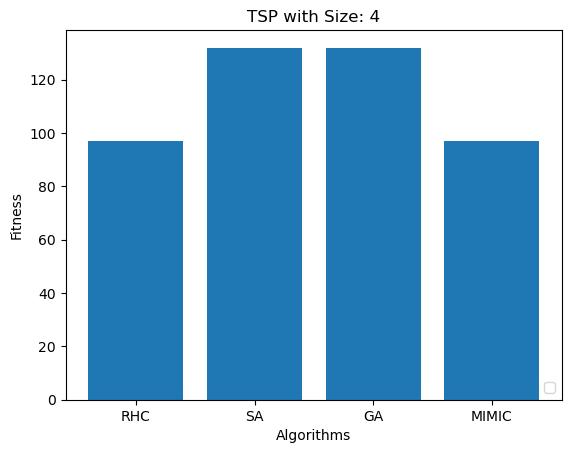

RHC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.673393964767456
SA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


10.281784296035767
GA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


32.87895321846008
MIMIC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


2522.45605635643


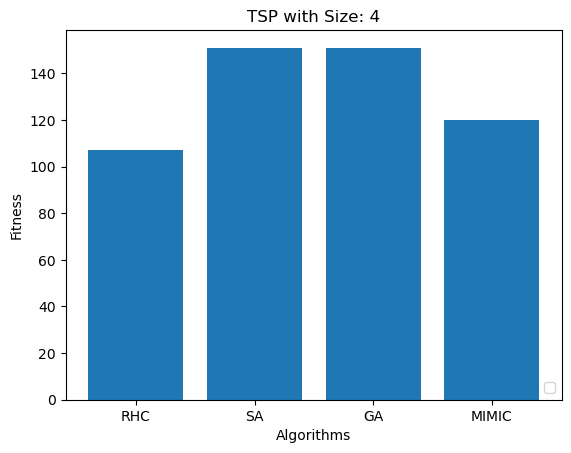

ERROR:root:Problem restoring SIGNINT handler


RHC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.5804483890533447
SA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


10.210243940353394
GA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


23.35118079185486
MIMIC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


2308.726672410965


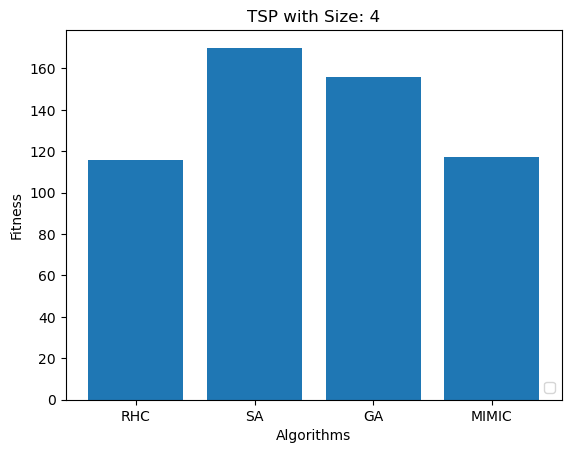

ERROR:root:Problem restoring SIGNINT handler


RHC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.4668843746185303
SA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


10.902694463729858
GA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


19.118618726730347
MIMIC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


6078.46188044548


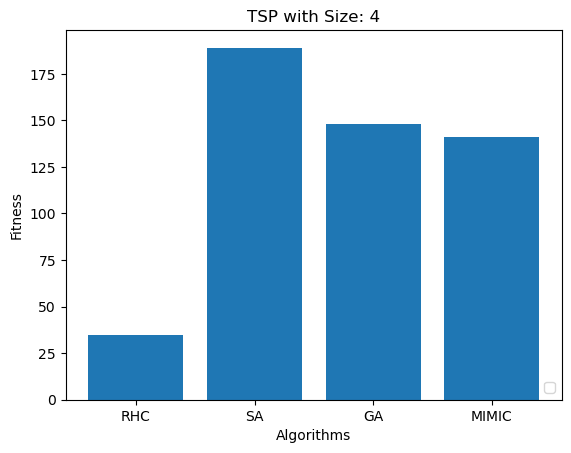

ERROR:root:Problem restoring SIGNINT handler


RHC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.5189907550811768
SA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


13.780449867248535
GA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


46.58541464805603
MIMIC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


15787.758092880249


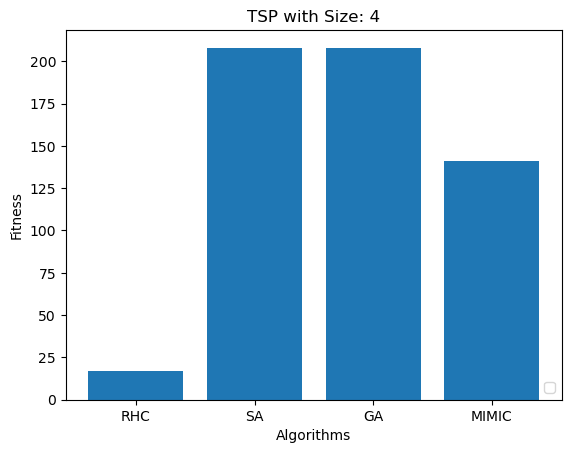

ERROR:root:Problem restoring SIGNINT handler


RHC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.6146886348724365
SA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


15.353987693786621
GA


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


29.607978343963623
MIMIC


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


7169.319283246994


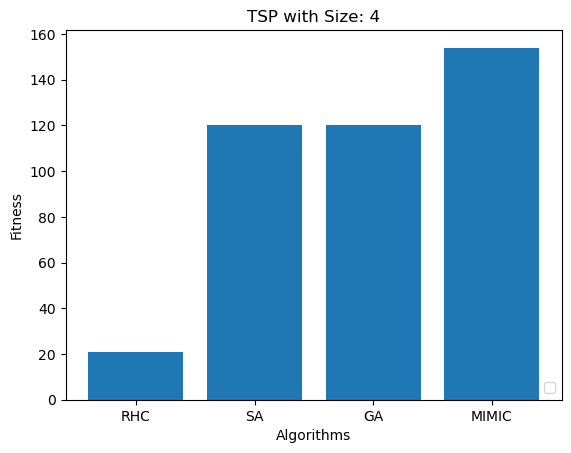

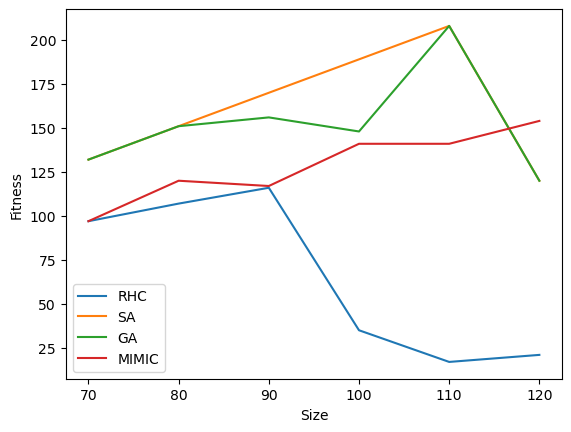

In [70]:
rhc_s = []
sa_s = []
ga_s = []
mimic_s = []
for x in range(70,130,10):
    # RHC
    print('RHC')
    start_time = time.time()
    rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                    prob = 'contp', 
                    algorithm = 'rhc', 
                    restarts = 2,
                    size = x,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = 500)
    end_time = time.time()
    rhc_time = end_time - start_time                                                                                  
    print(rhc_time)

    # max_iters = 500, max_attempts = 100, restart = 2

    # SA
    print('SA')
    start_time = time.time()
    sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                      prob = 'contp', 
                      algorithm = 'sa', 
                      size = x,
                      init_state = None, 
                      curve = True, 
                      random_state = 42, 
                      max_attempts = 5000, 
                      max_iters = 5000,
                      schedule = mlrose_hiive.GeomDecay(init_temp=10000, decay=0.99, min_temp = 0.1))
    end_time = time.time()
    sa_time = end_time - start_time
    print(sa_time)

    # max attempts = 5000, schedule: geometric, init_temp = 10000, max_iters = 5000, decay=0.99, min_temp=0.1

    # GA
    print('GA')
    start_time = time.time()
    ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                        prob = 'contp', 
                        algorithm = 'ga', 
                        size = x,
                        init_state = None, 
                        curve = True, 
                        random_state = 42, 
                        max_attempts = 100, 
                        max_iters = 700,
                        pop_size_ga = 200, 
                        mutation_prob = 0.3)
    end_time = time.time()
    ga_time = end_time - start_time
    print(ga_time)

    # mutation rate = 0.3, popsize = 200, iter = 700, max attempt: 100

    # MIMIC
    print('MIMIC')
    start_time = time.time()
    m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                        prob = 'contp', 
                        algorithm = 'mimic', 
                        size = x,
                        init_state = None, 
                        curve = True, 
                        random_state = 42, 
                        max_attempts = 100, 
                        max_iters = 5000,
                        pop_size_mimic = 250, 
                        keep_pct = 0.5)
    #                     , 
    #                     fast_mimic = False
    end_time = time.time()
    m_time = end_time - start_time      
    print(m_time)
    
    # population size: 250, Keep pct: 0.5, max_iters: 5000, max_attempt = 100

    categories = ['RHC','SA','GA','MIMIC']
    values = [rhc_best_fitness, sa_best_fitness, ga_best_fitness, m_best_fitness]
    plt.clf()
    plt.bar(categories, values)

    plt.xlabel('Algorithms')
    plt.ylabel('Fitness')
    plt.title(f'TSP with Size: {i}')
    plt.legend(loc = 'lower right')    
    plt.show()

    
    
    rhc_s.append(rhc_best_fitness)
    sa_s.append(sa_best_fitness)
    ga_s.append(ga_best_fitness)
    mimic_s.append(m_best_fitness)


plt.clf()
x = np.arange(70,130,10)
plt.plot(x, rhc_s, label='RHC')
plt.plot(x, sa_s, label='SA')
plt.plot(x, ga_s, label='GA')
plt.plot(x, mimic_s, label='MIMIC')

# Adding labels and legend
plt.xlabel('Size')
plt.ylabel('Fitness')
plt.legend(loc = 'lower left')    



# 3.3 Optimization Problem - FEval per Iteration

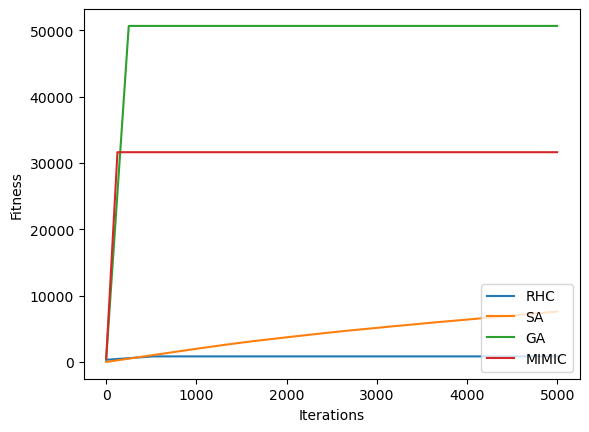

In [89]:
# Fitness per iteration!

rhc = []
sa = []
ga = []
mimic = []

for i in range(0,max(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve))):    
    try:
        rhc.append(rhc_fitness_curve[i][1])
    except:
        rhc.append(rhc_fitness_curve[-1][1])
    
    try:
        sa.append(sa_fitness_curve[i][1])
    except:
        sa.append(sa_fitness_curve[-1][1])
    
    try:
        ga.append(ga_fitness_curve[i][1])
    except:
        ga.append(ga_fitness_curve[-1][1])
        
    try:
        mimic.append(m_fitness_curve[i][1])
    except:
        mimic.append(m_fitness_curve[-1][1])

plt.clf()
x = np.arange(max(len(rhc_fitness_curve),len(sa_fitness_curve),len(ga_fitness_curve),len(m_fitness_curve)))
plt.plot(x, rhc, label='RHC')
plt.plot(x, sa, label='SA')
plt.plot(x, ga, label='GA')
plt.plot(x, mimic, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend(loc = 'lower right')

# plt.show()
# print(x)

ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


5
0.08294916152954102
0.04819059371948242


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.8542234897613525


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


162.5522608757019
6
0.054019927978515625
0.025623083114624023


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.6984176635742188


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


170.15781259536743
7
0.057790517807006836
0.028853654861450195


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.7556266784667969


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


201.99467587471008
8
0.045702219009399414
0.024934053421020508


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


0.8759622573852539


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


228.41145634651184
9
0.06417179107666016
0.03233599662780762


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


1.077594518661499


ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler
ERROR:root:Problem restoring SIGNINT handler


256.49138283729553


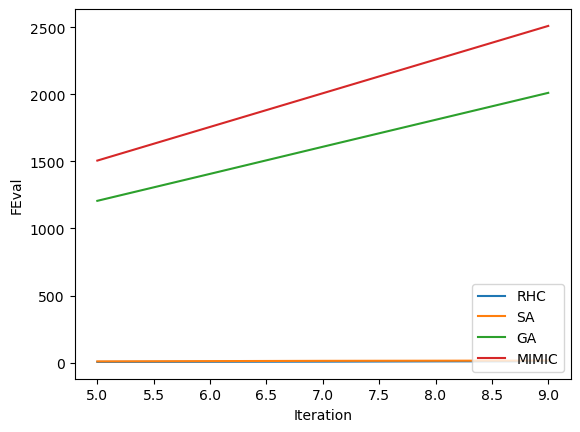

In [71]:
rhc_fe = []
sa_fe = []
ga_fe = []
m_fe = []
x = []

for i in range(5,10):
    print(i)
    start_time = time.time()
    rhc_best_state, rhc_best_fitness, rhc_fitness_curve, rhc_size, rhc_feval_iteration, rhc_feval_time, rhc_df_run_stats, rhc_df_run_curves = ro(
                prob = 'contp', 
                algorithm = 'rhc', 
                restarts = 2,
                size = 100,
                init_state = None, 
                curve = True, 
                random_state = 42, 
                max_attempts = 100, 
                max_iters = i)
    end_time = time.time()
    rhc_fe_time = end_time - start_time  
    print(rhc_fe_time)
    
    # max_iters = 500, max_attempts = 100, restart = 2  

    start_time = time.time()
    sa_best_state, sa_best_fitness, sa_fitness_curve, sa_size, sa_feval_iteration, sa_feval_time, sa_df_run_stats, sa_df_run_curves = ro(
                  prob = 'contp', 
                  algorithm = 'sa', 
                  size = 12,
                  init_state = None, 
                  curve = True, 
                  random_state = 42, 
                  max_attempts = 500, 
                  max_iters = i,
                  schedule = mlrose_hiive.GeomDecay())
    end_time = time.time()
    sa_fe_time = end_time - start_time 
    print(sa_fe_time)
    
    # max attempts = 5000, schedule: geometric, init_temp = 10000, max_iters = 5000, decay=0.99, min_temp=0.1
    
    start_time = time.time()
    ga_best_state, ga_best_fitness, ga_fitness_curve, ga_size, ga_feval_iteration, ga_feval_time, ga_df_run_stats, ga_df_run_curves = ro(
                    prob = 'contp', 
                    algorithm = 'ga', 
                    size = 100,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = i,
                    pop_size_ga = 200, 
                    mutation_prob = 0.4)
    end_time = time.time()
    ga_fe_time = end_time - start_time 
    print(ga_fe_time)
    
    # mutation rate = 0.3, popsize = 200, iter = 700, max attempt: 100
    
    start_time = time.time()
    m_best_state, m_best_fitness, m_fitness_curve, m_size, m_feval_iteration, m_feval_time, m_df_run_stats, m_df_run_curves = ro(
                    prob = 'contp', 
                    algorithm = 'mimic', 
                    size = 100,
                    init_state = None, 
                    curve = True, 
                    random_state = 42, 
                    max_attempts = 100, 
                    max_iters = i,
                    pop_size_mimic = 250, 
                    keep_pct = 0.5)
    end_time = time.time()
    m_fe_time = end_time - start_time 
    print(m_fe_time)
    
    # population size: 250, Keep pct: 0.5, max_iters: 5000, max_attempt = 100

    
    x.append(i)
    
    specific_rows = rhc_df_run_stats[rhc_df_run_stats['Iteration'] == i].reset_index()
    rhc_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = sa_df_run_stats[sa_df_run_stats['Iteration'] == i].reset_index()
    sa_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = ga_df_run_stats[ga_df_run_stats['Iteration'] == i].reset_index()
    ga_fe.append(specific_rows.loc[0, 'FEvals'])
    
    specific_rows = m_df_run_stats[m_df_run_stats['Iteration'] == i].reset_index()
    m_fe.append(specific_rows.loc[0, 'FEvals'])
        

plt.clf()
plt.plot(x, rhc_fe, label='RHC')
plt.plot(x, sa_fe, label='SA')
plt.plot(x, ga_fe, label='GA')
plt.plot(x, m_fe, label='MIMIC')

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('FEval')
plt.legend(loc = 'lower right')

# Part 2: Neural Network

# Defining functions for Neural Network that:
1. Ingest Dataset and Scale Dataset 
2. Conduct Train Test Split

In [8]:
def data_ingestion():
    # Ingesting Wine Quality Dataset
    wine = pd.read_csv(r'C:\Users\marcu\Desktop\GA Tech\ML\ML-SP24\Assignment 2\winequality-white.csv')
    column_names = wine.columns.tolist()
    # Standardize the values in all columns
    scaler = StandardScaler()
    columns_stand = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
    wine[columns_stand] = scaler.fit_transform(wine[columns_stand])
    
    # Encoding quality wine 
    label_encoder = LabelEncoder()
    wine['encoded_quality'] = label_encoder.fit_transform(wine['quality'])
    wine = wine.drop(columns=['quality'])
    wine = wine.rename(columns={'encoded_quality': 'quality'})


    # Descriptive Stats for Wine
    df_wine = wine.describe()
    df_wine.to_csv('descriptive/descriptive_stats_wine.csv')

    # Output boxplot for outlier distribution
    column_names = wine.columns.tolist()
    for i in column_names:
        column_data = wine[i].values
        # Create boxplot using Matplotlib
        plt.clf()
        plt.boxplot(column_data)
        plt.title(f'Box and Whisker Plot for Wine Quality for {i}')
        plt.savefig(f'image/wine_{i}.png')

    # Plotting Target Variable for Apple Quality
    plt.clf()
#     plt.hist(wine['quality'], label=i)
    plt.savefig('image/wine_target.png', bbox_inches='tight')
    
    # Ingesting Apple Quality
    aq = pd.read_csv(r'C:\Users\marcu\Desktop\GA Tech\ML\ML-SP24\Assignment 2\apple_quality.csv')
    # Descriptive Stats for Wine
    df_aq = aq.describe()
    df_aq.to_csv('descriptive/descriptive_stats_aq.csv')
    
    # Output boxplot for outlier distribution
    column_names = aq.columns.tolist()
    for i in column_names:
        column_data = aq[i].values
        # Create boxplot using Matplotlib
        plt.clf()
        plt.boxplot(column_data)
        plt.title(f'Box and Whisker Plot for Apple Quality for {i}')
        plt.savefig(f'image/aq_{i}.png')

    # Plotting Target Variable for Apple Quality
    plt.clf()
#     plt.hist(aq['Quality'], label=i)
    plt.savefig('image/apple_target.png', bbox_inches='tight')
    
    return(wine,aq)

In [7]:
def train_test(wine, aq):
    list_w = wine.columns.tolist()
    list_w.remove('quality')
    x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(wine[list_w], wine['quality'], test_size=0.3, random_state=42)

    list_a = aq.columns.tolist()
    list_a.remove('Quality')
    x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(aq[list_a], aq['Quality'], test_size=0.3, random_state=42)

    return(x_train_w, x_test_w, y_train_w, y_test_w, x_train_a, x_test_a, y_train_a, y_test_a)

In [9]:
def strat_kfold_ann(clf, num_folds, x_train, y_train, dataset = 'wine', epochs = 5):
    # Create a StratifiedKFold object
    stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True,random_state = 42)
    
    # Lists to store training and validation scores for each fold
    training_scores = []
    validation_scores = []
    
    # Iterate over folds
    for fold_num, (train_index, val_index) in enumerate(stratified_kfold.split(x_train, y_train), start=1):


        # Extract training and validation sets for this fold
        X_train_sub, X_val_sub = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_sub, y_val_sub = y_train.iloc[train_index], y_train.iloc[val_index]
        
        
        # One hot encoding
        encoder = OneHotEncoder(sparse=False)
        y_train_hot = encoder.fit_transform(y_train_sub.values.reshape(-1, 1))
        y_val_hot = encoder.transform(y_val_sub.values.reshape(-1, 1))
        
        
        # Train the Decision Tree model
        clf.fit(X_train_sub, y_train_hot)

        if dataset == 'wine':
            # Make predictions on the training set
            predictions_train = clf.predict(X_train_sub)
            y_train_pred = np.argmax(predictions_train, axis=1)
            
            # Converting y_train_sub into the quality category 
            y_train_sub = np.argmax(y_train_hot, axis=1)
            
            # Make predictions on the validation set
            predictions_val = clf.predict(X_val_sub)
            y_val_pred = np.argmax(predictions_val, axis=1)
            
            # Converting y_train_sub into the quality category 
            y_val_sub = np.argmax(y_val_hot, axis=1)

        else:            
            # Make predictions on the training set
            predictions_train = clf.predict(X_train_sub)
            y_train_pred = np.argmax(predictions_train, axis=1)
            
            # Converting y_train_sub into the quality category 
            y_train_sub = np.argmax(y_train_hot, axis=1)
            
            # Make predictions on the validation set
            predictions_val = clf.predict(X_val_sub)
            y_val_pred = np.argmax(predictions_val, axis=1)
            
            # Converting y_train_sub into the quality category 
            y_val_sub = np.argmax(y_val_hot, axis=1)

        # Calculate recall scores for training set
        _, recall_train, _, _ = precision_recall_fscore_support(y_train_sub, y_train_pred, average='micro')
        training_scores.append(recall_train)

        # Calculate recall scores for validation sets
        _, recall_val, _, _ = precision_recall_fscore_support(y_val_sub, y_val_pred, average='micro')
        validation_scores.append(recall_val)

    # Print mean scores across all folds
    mean_training_score = np.mean(training_scores)
    mean_validation_score = np.mean(validation_scores)
#     print(mean_validation_score, mean_training_score)
    return(mean_validation_score, mean_training_score)

tf.random.set_seed(42)

In [10]:
# Data ingestion
wine,aq = data_ingestion()
x_train_w, x_test_w, y_train_w, y_test_w, x_train_a, x_test_a, y_train_a, y_test_a = train_test(wine,aq)

<Figure size 640x480 with 0 Axes>

In [11]:
# Base Case Fitness Curve (one-off)
base_fit_curve = []

start_time = time.time()
nn_model_base_curve = mlrose_hiive.NeuralNetwork(hidden_nodes = [64,64,64], activation = 'tanh', 
                             algorithm = 'gradient_descent', max_iters = 500*i, 
                             bias = True, is_classifier = True, learning_rate = 0.0001, 
                             early_stopping = True, clip_max = 5, max_attempts = 100, 
                             random_state = 42, curve = True, restarts = 0)
val, train = strat_kfold_ann(nn_model_base_curve, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)
# print('nodes: ', nodes[i], 'activations: ', activation[x], 'LR: ', learning_rate[y], 'validation recall: ', val , 'training recall: ', train)
end_time = time.time()
wall_clock_time = end_time - start_time  
print(wall_clock_time)
print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)

base_fit_curve.append(nn_model_base_curve.fitness_curve)

83.88173985481262
validation recall:  0.8771428571428571 training recall:  1.0 wall clock time:  83.88173985481262


In [74]:
# Base Case Fitness Curve - iterated
base_fit_curve = []
base_val = []
base_train=[]

for i in range(0,11):
    start_time = time.time()
    nn_model_base_curve = mlrose_hiive.NeuralNetwork(hidden_nodes = [64,64,64], activation = 'tanh', 
                                 algorithm = 'gradient_descent', max_iters = 500*i, 
                                 bias = True, is_classifier = True, learning_rate = 0.0001, 
                                 early_stopping = True, clip_max = 5, max_attempts = 100, 
                                 random_state = 42, curve = True, restarts = 0)
    val, train = strat_kfold_ann(nn_model_base_curve, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)
    # print('nodes: ', nodes[i], 'activations: ', activation[x], 'LR: ', learning_rate[y], 'validation recall: ', val , 'training recall: ', train)
    
    base_val.append(val)
    base_train.append(train)
    end_time = time.time()
    wall_clock_time = end_time - start_time  
    print(wall_clock_time)
    print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)

    base_fit_curve.append(nn_model_base_curve.fitness_curve)

0.02193164825439453
validation recall:  0.4692857142857143 training recall:  0.4692857142857143 wall clock time:  0.02193164825439453
7.576593637466431
validation recall:  0.8642857142857143 training recall:  0.9989285714285714 wall clock time:  7.576593637466431
15.306929111480713
validation recall:  0.8689285714285715 training recall:  1.0 wall clock time:  15.306929111480713
22.58916711807251
validation recall:  0.8710714285714286 training recall:  1.0 wall clock time:  22.58916711807251
30.628763675689697
validation recall:  0.8696428571428572 training recall:  1.0 wall clock time:  30.628763675689697
37.75081729888916
validation recall:  0.8721428571428571 training recall:  1.0 wall clock time:  37.75081729888916
45.72975254058838
validation recall:  0.8725 training recall:  1.0 wall clock time:  45.72975254058838
52.627859354019165
validation recall:  0.8746428571428572 training recall:  1.0 wall clock time:  52.627859354019165
60.08501720428467
validation recall:  0.875714285714

In [12]:
# RHC Fitness Curve (one-off)

rhc_fit_curve = []

start_time = time.time()
nn_model_base_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes = [64,64,64], activation = 'tanh', 
                                                 algorithm = 'random_hill_climb', max_iters = 500*i, 
                                                 bias = True, is_classifier = True, learning_rate = 0.0001, 
                                                 early_stopping = True, clip_max = 5, max_attempts = 100, 
                                                 random_state = 42, curve = True, restarts = 3)
val, train = strat_kfold_ann(nn_model_base_rhc, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)


end_time = time.time()
wall_clock_time = end_time - start_time
rhc_fit_curve.append(nn_model_base_rhc.fitness_curve)
print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)


validation recall:  0.4692857142857143 training recall:  0.4692857142857143 wall clock time:  147.40604543685913


In [75]:
# RHC Fitness Curve (iterated)

rhc_fit_curve = []
rhc_val = []
rhc_train=[]

for i in range(0,11):
    start_time = time.time()
    nn_model_base_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes = [64,64,64], activation = 'tanh', 
                                                     algorithm = 'random_hill_climb', max_iters = 500*i, 
                                                     bias = True, is_classifier = True, learning_rate = 0.0001, 
                                                     early_stopping = True, clip_max = 5, max_attempts = 100, 
                                                     random_state = 42, curve = True, restarts = 3)
    val, train = strat_kfold_ann(nn_model_base_rhc, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)
    
    rhc_val.append(val)
    rhc_train.append(train)
    
    end_time = time.time()
    wall_clock_time = end_time - start_time
    rhc_fit_curve.append(nn_model_base_rhc.fitness_curve)
    print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)


validation recall:  0.5214285714285714 training recall:  0.5214285714285714 wall clock time:  0.041811466217041016
validation recall:  0.52 training recall:  0.5203571428571429 wall clock time:  14.864858865737915
validation recall:  0.5728571428571428 training recall:  0.5728571428571428 wall clock time:  28.982013702392578
validation recall:  0.4642857142857143 training recall:  0.4642857142857143 wall clock time:  43.639010190963745
validation recall:  0.5249999999999999 training recall:  0.5249999999999999 wall clock time:  58.71653890609741
validation recall:  0.64 training recall:  0.6403571428571428 wall clock time:  73.19672203063965
validation recall:  0.5457142857142857 training recall:  0.5457142857142857 wall clock time:  87.75945544242859
validation recall:  0.5017857142857143 training recall:  0.5021428571428572 wall clock time:  102.30535769462585
validation recall:  0.5264285714285715 training recall:  0.5275 wall clock time:  118.13560271263123
validation recall:  0.55

In [70]:
# SA Fitness Curve (one-off)

sa_fit_curve = []

start_time = time.time()
nn_model_base_sa = mlrose_hiive.NeuralNetwork([64,64,64], activation = 'tanh', 
             algorithm = 'simulated_annealing', max_iters = 1000,
             bias = True, is_classifier = True, learning_rate = 0.8, 
             early_stopping = True, clip_max = 5, max_attempts = 100, 
             random_state = 42, curve = True, restarts = 0, schedule = mlrose_hiive.GeomDecay(init_temp = 10000, decay=0.8, min_temp=0.1))
val, train = strat_kfold_ann(nn_model_base_sa, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)
end_time = time.time()
sa_fit_curve.append(nn_model_base_sa.fitness_curve)
wall_clock_time = end_time - start_time
print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)


validation recall:  0.4692857142857143 training recall:  0.46964285714285714 wall clock time:  390.93183994293213


In [76]:
# SA Fitness Curve (iterated)
sa_fit_curve = []
sa_val=[]
sa_train =[]

for i in range(0,11):
    start_time = time.time()
    nn_model_base_sa = mlrose_hiive.NeuralNetwork([64,64,64], activation = 'tanh', 
                 algorithm = 'simulated_annealing', max_iters = 500*i,
                 bias = True, is_classifier = True, learning_rate = 0.8, 
                 early_stopping = True, clip_max = 5, max_attempts = 100, 
                 random_state = 42, curve = True, restarts = 0, schedule = mlrose_hiive.GeomDecay(init_temp = 10000, decay=0.8, min_temp=0.1))
    val, train = strat_kfold_ann(nn_model_base_sa, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)
    
    sa_val.append(val)
    sa_train.append(train)
    
    end_time = time.time()
    sa_fit_curve.append(nn_model_base_sa.fitness_curve)
    wall_clock_time = end_time - start_time
    print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)


validation recall:  0.4692857142857143 training recall:  0.4692857142857143 wall clock time:  0.022896289825439453
validation recall:  0.5514285714285714 training recall:  0.5532142857142857 wall clock time:  4.864107847213745
validation recall:  0.5364285714285715 training recall:  0.5203571428571429 wall clock time:  9.737185716629028
validation recall:  0.5289285714285714 training recall:  0.5267857142857143 wall clock time:  14.533360004425049
validation recall:  0.5328571428571429 training recall:  0.5317857142857143 wall clock time:  19.362060546875
validation recall:  0.5428571428571428 training recall:  0.5642857142857143 wall clock time:  24.32830572128296
validation recall:  0.5507142857142857 training recall:  0.5503571428571429 wall clock time:  28.832399606704712
validation recall:  0.615 training recall:  0.63 wall clock time:  33.59438681602478
validation recall:  0.5982142857142857 training recall:  0.6192857142857143 wall clock time:  38.86462759971619
validation recal

In [14]:
# GA Fitness Curve (one-off)

ga_fit_curve=[]


nn_model_base_ga = mlrose_hiive.NeuralNetwork([64,64,64], activation = 'tanh', 
                     algorithm = 'genetic_alg', max_iters = 500*i, 
                     bias = True, is_classifier = True, learning_rate = 0.0001, 
                     early_stopping = True, clip_max = 5, max_attempts = 100, 
                     random_state = 42, curve = True, restarts = 0, schedule = 0, pop_size = 500, mutation_prob = 0.5)
val, train = strat_kfold_ann(nn_model_base_ga, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)
end_time = time.time()
ga_fit_curve.append(nn_model_base_ga.fitness_curve)
wall_clock_time = end_time - start_time
print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)


validation recall:  0.6467857142857143 training recall:  0.6375 wall clock time:  2015.0797204971313


In [78]:
# GA Fitness Curve (iterated)

ga_fit_curve=[]
ga_val=[]
ga_train =[]

for i in range(1,11):
    nn_model_base_ga = mlrose_hiive.NeuralNetwork([64,64,64], activation = 'tanh', 
                         algorithm = 'genetic_alg', max_iters = 20*i, 
                         bias = True, is_classifier = True, learning_rate = 0.0001, 
                         early_stopping = True, clip_max = 5, max_attempts = 100, 
                         random_state = 42, curve = True, restarts = 0, schedule = 0, pop_size = 500, mutation_prob = 0.5)
    val, train = strat_kfold_ann(nn_model_base_ga, num_folds=2, x_train = x_train_a, y_train = y_train_a, dataset = 'apple', epochs = 5)
    
    ga_val.append(val)
    ga_train.append(train)
    
    end_time = time.time()
    ga_fit_curve.append(nn_model_base_ga.fitness_curve)
    wall_clock_time = end_time - start_time
    print('validation recall: ', val , 'training recall: ', train,  'wall clock time: ', wall_clock_time)


validation recall:  0.6246428571428572 training recall:  0.6232142857142857 wall clock time:  8994.834370851517
validation recall:  0.6057142857142856 training recall:  0.6174999999999999 wall clock time:  9361.245974302292
validation recall:  0.6164285714285714 training recall:  0.6410714285714285 wall clock time:  9903.617369413376
validation recall:  0.6360714285714286 training recall:  0.6496428571428572 wall clock time:  13752.407793521881
validation recall:  0.6360714285714286 training recall:  0.6496428571428572 wall clock time:  28373.617102384567
validation recall:  0.6060714285714286 training recall:  0.6328571428571428 wall clock time:  40192.47764158249
validation recall:  0.6467857142857143 training recall:  0.6375 wall clock time:  53746.12161254883
validation recall:  0.6467857142857143 training recall:  0.6375 wall clock time:  55210.83976864815
validation recall:  0.6467857142857143 training recall:  0.6375 wall clock time:  56763.540784835815
validation recall:  0.646